In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8, 8) # set default figure size, 8in by 8in

# Motivating Example

Lets say that you wanted to predict how much a house is worth.  There are lots of properties of a house
that might affect its price.  We will usually refer to such properties as "features" or "inputs" of our
model.  Likewise, the task we are trying to perform, predict house price based on the features of the house,
can be thought of as building a "model" or a "hypothesis" of the relationship between such features and
the price of a house.

Lets take a simple example to illustrate.  Lets say we have the following set of data about the relationship
between the size of houses and their prices (taken from real sales data of housing prices from some time
period in Portland Oregon):

''

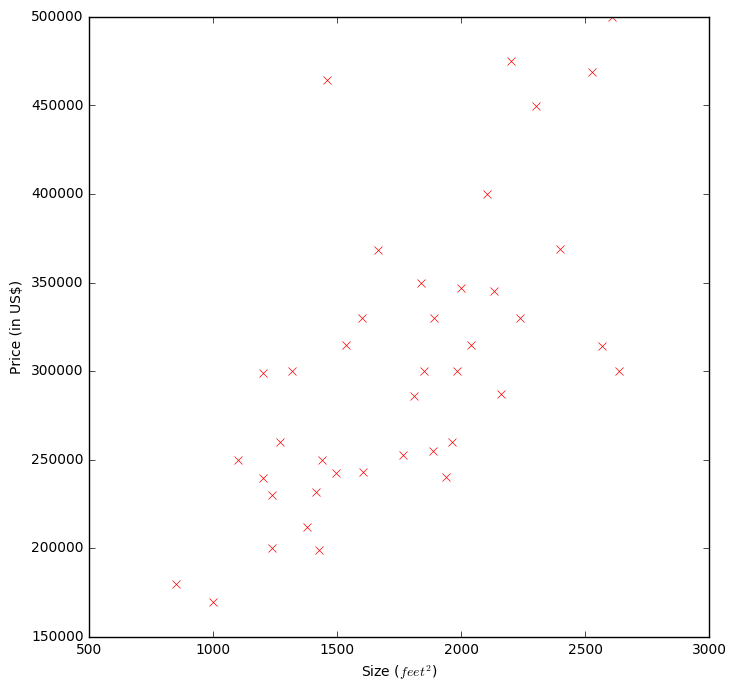

In [3]:
house = pd.read_csv('data/housing-prices-portland-or.csv')
house = house[house['size'] < 3000]   # only use the data for houses less than 3000 square feet, to simplify discussion
plt.plot(house['size'], house['price'], 'rx')
plt.xlabel('Size ($feet^2$)')
plt.ylabel('Price (in US$)')
''

# Linear Regression of 1 Feature

You may have run across the idea of fitting a straight line to a set of data.  For our house pricing data, it
seems reasonable (for the data from 900 to 3000 square feet) that the price of the house is 
 approximated as some linear function of its size.  We could fit a line to this data using
`NumPy` and see what we get like this:

In [4]:
coef = np.polyfit(house['size'], house['price'], 1) # fit a line (degree 1 polynomial) to the data
hypothesis = np.poly1d(coef)
print coef

[   116.29679832  98823.07611906]


In [5]:
print hypothesis

 
116.3 x + 9.882e+04


''

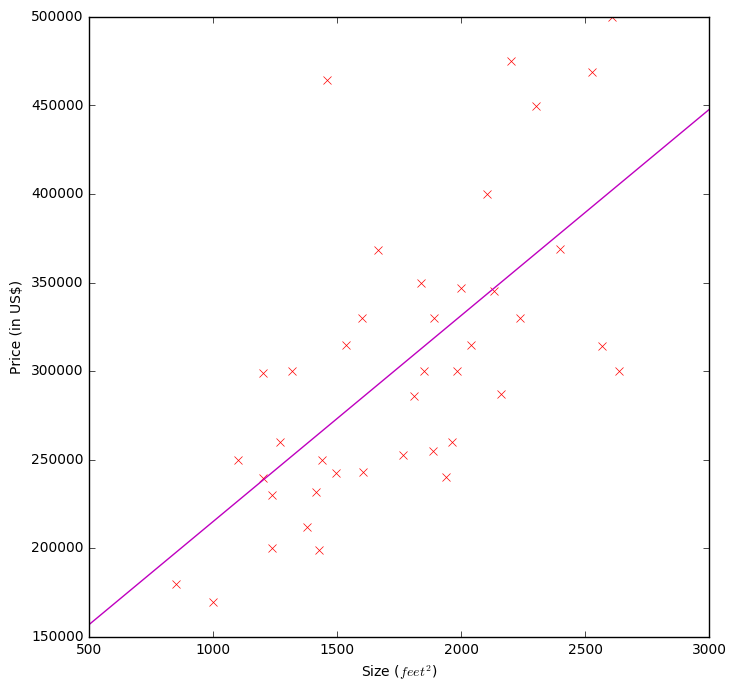

In [6]:
size = np.arange(500, 3000, 1) # ask model to predict prices for all sizes from 500 to 3000 sq ft
estimated_price = hypothesis(size)

# replot raw data
plt.plot(house['size'], house['price'], 'rx')
plt.xlabel('Size ($feet^2$)')
plt.ylabel('Price (in US$)')
#plt.axis([-100, 3000, 75000, 500000])
#Overlay the fitted model
plt.plot(size, estimated_price, 'm-')
''

# Some Notation

In machine learning literature/research, it is common to use the following standard notations

- $\mathbf{m}$ = Number of training examples
- $\mathbf{x}$'s = "input" variable / feature
- $\mathbf{y}$'s = "output" variable / "target" variable

In our training set data, we have the following for m, x, y

In [7]:
m = len(house) 
print "Number of training examples: ", m

# an example of converting from a pandas data frame to a numpy matrix/array
# this will be useful later...
x = house['size'].as_matrix() 
print x
y = house['price'].as_matrix()
print y


Number of training examples:  41
[2104 1600 2400 1416 1985 1534 1427 1380 1494 1940 2000 1890 1268 2300 1320
 1236 2609 1767 1888 1604 1962 1100 1458 2526 2200 2637 1839 1000 2040 1811
 1437 1239 2132 2162 1664 2238 2567 1200  852 1852 1203]
[399900 329900 369000 232000 299900 314900 198999 212000 242500 239999
 347000 329999 259900 449900 299900 199900 499998 252900 255000 242900
 259900 249900 464500 469000 475000 299900 349900 169900 314900 285900
 249900 229900 345000 287000 368500 329900 314000 299000 179900 299900
 239500]


Given we have assigned the training features (house sizes) to the `x` variable and the training output
(house prices) to the `y` variable, we can access the ith training item using array indexing.  
We will be using the following mathemetical notation for the ith value of a vector:

$$( x^{(i)}, y^{(i)} )$$

This is not meant to representing raising to a power.  This means we want the ith elements
of the `x` and `y` vectors.  We can get the ith element from the numpy arrays using array indexing:

In [8]:
print x[0], y[0]
print x[40], y[40]

2104 399900
1203 239500


# How do we represent our Hypothesis?


We are using the hypothesis that our data can be modeled as a straight line.  We have 1 input feature $x$
we want to use to predict 1 output feature $y$.  We can create a model using 2 parameters, the slope and 
intercept of a line.  We will call the 2 parameters we are using $\theta_1$ and $\theta_0$ the intercept and the slope of the line respectively:

$$h_\theta(x) = \theta_1 + \theta_0x$$

When we used the numpy `polyfit` function, we were basically fitting a straight line to the data, and 
this line represents a model, or a hypothesis, of the relationship of the size of the house 
to the cost of the house
that we should predict.  The coefficients we returned from calling the `polyfit` function represent
the slope and intercept of the straight line that best fit the data. 

In [9]:
theta = np.polyfit(x, y, 1)
print theta[1], theta[0]

98823.0761191 116.296798317


For example, the hypothesis, or model estimate, for some size house, say 1250 square feet, can be
found using the `NumPy` `poly1d` function, or by hand, like this:

In [10]:
size = 1250
hypothesis = np.poly1d(theta)
print hypothesis(size)

print theta[1] + theta[0] * size

244194.074015
244194.074015


The $\theta$ coefficients represent parameters of the model we are trying to build that best represents the
data.  We could try and find the $\theta$ coefficients by hand, for example, we could simply guess coefficients
and plot till it "looks" like the line fits the data well:

''

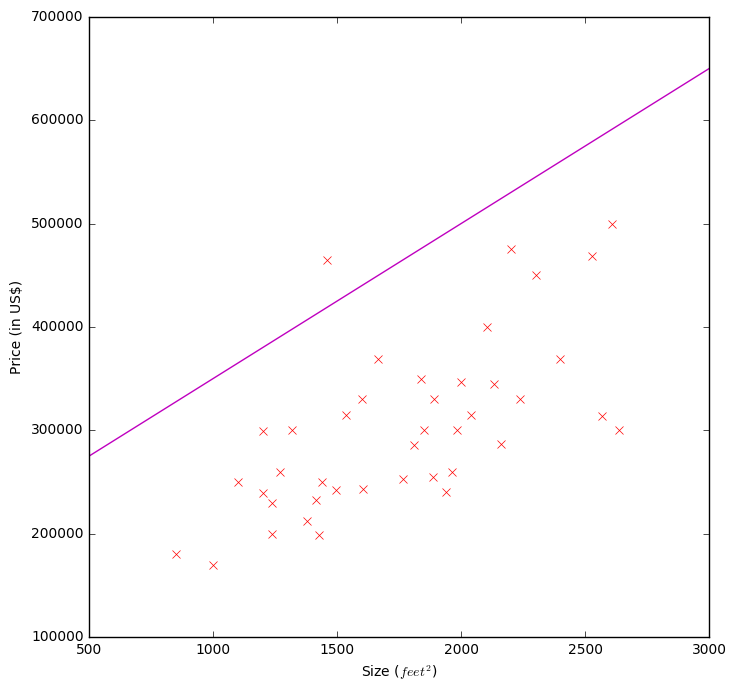

In [11]:
theta = np.array([150, 200000.0])
size = np.arange(500, 3000, 1) # ask model to predict prices for all sizes from 500 to 3000 sq ft
hypothesis = theta[1] + theta[0] * size

# replot raw data
plt.plot(x, y, 'rx')
plt.xlabel('Size ($feet^2$)')
plt.ylabel('Price (in US$)')
#plt.axis([-100, 3000, -5000, 500000])
#Overlay the fitted model
plt.plot(size, hypothesis, 'm-')
''

# How to Choose Parameters

Just guessing values for $\theta$ isn't very formal.  How do we decide which model is "best"?  Is there some
measure we can use that would more systematically and empirically help us to differentiate between different
values of the parameters and choose among them?

Previously we used a built in `numpy` method to choose the $\theta$ parameters for us for our
hypothesis.  Now we will see how this is actually done algorithmically.

We do this by formulating the problem in terms of a minimization.  So the idea is, for some set
of parameters $\theta$ that is a hypothesis, we can define a cost function:

$$cost = (h_\theta(x) - y)^2$$

The cost function is simply stating that we take the difference between our hypothesis or model
$h_\theta(x)$ and the actual output $y$, and then we square this difference.

This cost is only in terms of 1 particular input value $x$.  If we want to
know the overall cost, which is a measure of how well the $\theta$ parameters work as our model,
we need to sum up the cost over all of the input training patterns:

$$cost = \sum_{i=1}^{m} \big(h_\theta(x^{(i)}) - y^{(i)} \big)^2$$

We basically then take the average of this value.  Notice that when the predicted value is exactly correct
then the difference will be 0.  The further that the predicted value is from the correct value, the larger
the difference will be.  We square the difference so that when we sum them up, the positive and negative
differences don't cancel each other out (can also use the absolute value, for example).  This implies that
if the hypothesis makes every prediction correctly, the cost is 0.

To recap, the goal is to find some value for $\theta_0$ and $\theta_1$ such that the
calculated total cost is the minimum for any possible values of the $\theta$ parameters.

By convention, we use the notation $C$ for the cost function, and write it as:

$$C(\theta) = \frac{1}{2m} \sum_{i=1}^{m} \big(h_\theta(x^{(i)}) - y^{(i)} \big)^2$$

This function is commonly known as the squared error cost function (also sometimes called the squared
difference).

In [12]:
print y[0]
h1 = 390000
h2 = 400000

print (h1 - y[0])**2.0

print (h2 - y[0])**2.0


#theta = (115.0, 100000.0)
theta = (116.29679832,  98823.07611906)
s = 0.0
for i in range(m):
    hypothesis = theta[0] * x[i] + theta[1]
    s += (hypothesis - y[i])**2.0
    
print s / (2.0 * m)

399900
98010000.0
10000.0
1883753346.3


# Cost Function

Lets try and build up an intuition of how the cost function works.  First of all, lets build a simple Python
function that will calculate the cost function for any given set of parameters $\theta_0, \theta_1$

In [13]:
def cost_function(theta, x, y):
    """Calculate the squared error cost function.  We assume that the data has a single feature x, and are
    given the correct output for each input in y.  This function calculates the sum squared error cost
    for the given values of the theta parameters and returns this value as its result.
    """
    m = len(x) # should be true that m == len(x) == len(y)
    
    # sum up all of the squared differences
    s = 0.0
    for i in range(m):
        hypothesis = theta[1] + theta[0] * x[i]
        s += (hypothesis - y[i])**2.0 # calclulate the difference squared, add to running sum

    # turn into the average of the squared error
    s = s / (2.0 * float(m))
    return s

In [14]:
theta = np.array([116.296798317, 98823.0761191])
cost_function(theta, x, y)

1883753346.3031564

Recall that using the `NumPy` built in `polyfit()` function we were told that the best fit for a model line
occurs with parameters $\theta_0, \theta_1 = (116.296798317, 98823.0761191)$.  We showed what the cost
of that hypothesis was at that point in the previous cell.  The cost is not 0, did that surprise you?

We can build up an intiution that this is in fact the minimum cost that can be found for this set of data.
Lets hold the slope constant, and try a range of value for the intercept, and see what cost we get:

''

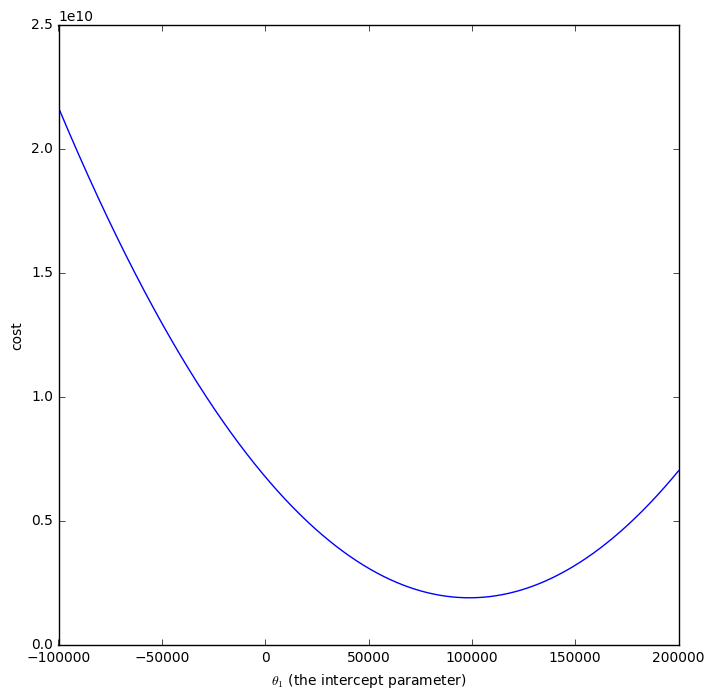

In [15]:
theta0 = 116.296798317
#theta0 = 150.0
intercepts = np.linspace(-100000, 200000, 1000) # hypothesis for an intercept from -10000 to 200000

costs = np.empty(intercepts.shape)

for i, theta1 in enumerate(intercepts):
    theta = (theta0, theta1)
    cost = cost_function(theta, x, y)
    costs[i] = cost
    
# visualize the resulting costs
plt.plot(intercepts, costs)
plt.xlabel('$\\theta_1$ (the intercept parameter)')
plt.ylabel('cost')
''

Make sure that you understand what we did in this previous figure.  We held the slope constant and calculated
the cost for a range of intercept values (the $\theta_0$ parameter of our hypothesis/model).  This figure
shows that the cost smoothly varies, and it has a minimum somewhere around an intercept parameter of 100000.
In fact, of course, the absolute minimum will occur when the intercept is 98823.0761191, as the `polyfit()`
function has already determined.

If you run the previous cell at a different value for the slope, you will see that the figure still looks like
a smooth parabola (try it).  The only difference will be that the minimum point of the cost will change.

We can do exactly the same analysis, but keep the interecept fixed at some value and try and vary the
slope parameter:

''

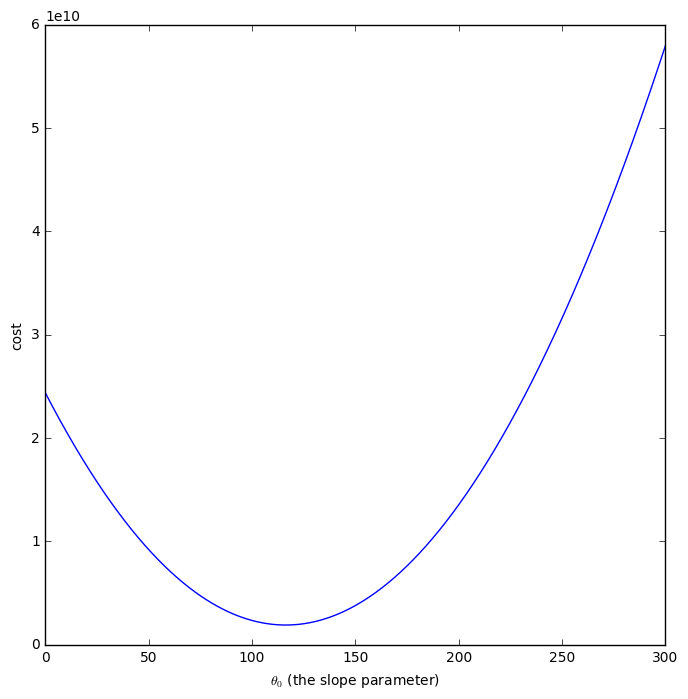

In [16]:
theta1 = 98823.0761191
#theta1 = 0
slopes = np.linspace(0, 300, 1000) # hypothesis for slopes ranging from 0 to 300

costs = np.empty(slopes.shape)

for i, theta0 in enumerate(slopes):
    theta = (theta0, theta1)
    cost = cost_function(theta, x, y)
    costs[i] = cost
    
# visualize the resulting costs
plt.plot(slopes, costs)
plt.xlabel('$\\theta_0$ (the slope parameter)')
plt.ylabel('cost')
''


Of course this still doesn't answer how we find which combination of slope/intercept $\theta_0, \theta_1$
parameters results in the minimum value.  It is harder to visualize, since we have to plot the cost as the
result of the two parameters.  However, we can create a contour plot, for example, that visualizes the cost
as contours of the 2 parameters of our model.  

Here we do just that.  On the right is a contour plot of our two $\theta$ parameters.  The lines of the
contour plot represent different levels of the cost function.  On the left is our original data.  We plot
the fitted line for a given set of $\theta_0, \theta_1$ parameters, and we show the location of this
set of parameters on the contour plot.  You should try varying the $\theta$ parameters in the next cell, to see
how the cost function changes as a result of modifying $\theta_0, \theta_1$

In [17]:
# create a vectorized version of the cost function.  Expects theta0 and theta1 parameters
# to be numpy arrays/matrices of corresponding theta parameter pairs
def cost_function_2(theta0, theta1, x, y):
    """Given theta0 and theta1 parameters for our hypothesis h(x) = theta0 + theta1 * x,
    calculate the sum squared difference cost function.  This function assumes that
    the training inputs are in a variable called x, and the correct outputs are in
    a variable called y, defined outside of this function"""
    m = len(x) # training set size
    sum = 0.0  # calculate the running sum squared error
    
    for i in range(0, m):
        sum += ((theta1 + theta0 * x[i]) - y[i])**2.0
        
    return (1.0 / (2.0 * m)) * sum

cost= 6734632074.78


''

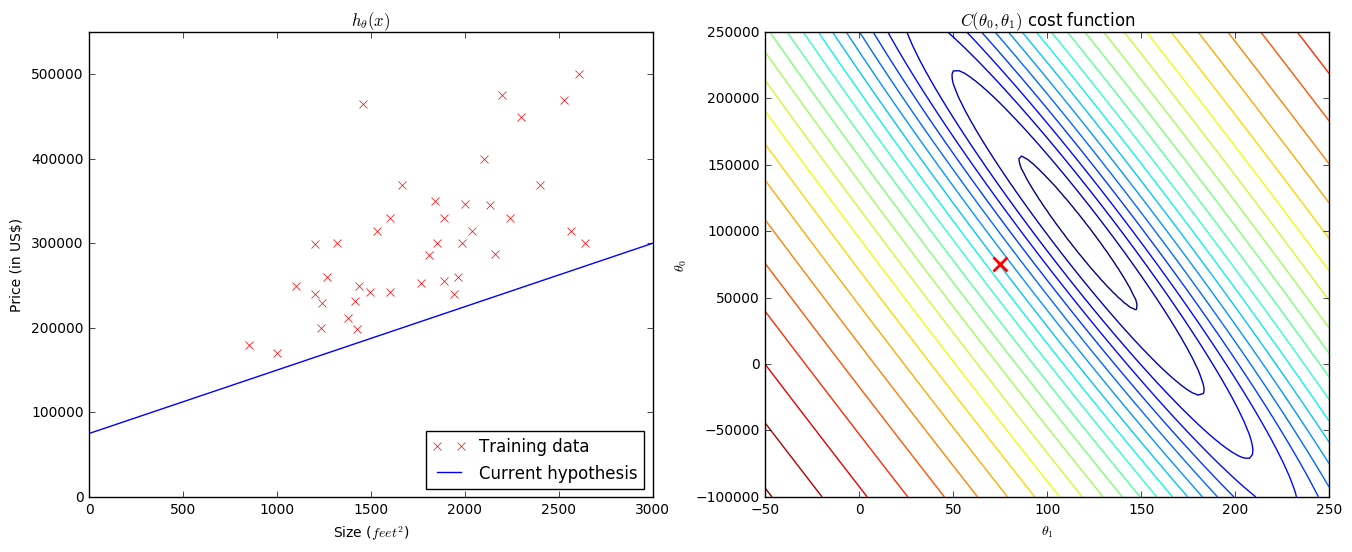

In [18]:
# change these in order to see how the hypothesis changes and the cost function changes
# as a function of the theta0 and theta1 parameters
theta0 = 75.0 # slope
theta1 = 75000.0 # intercept
theta = (theta0, theta1)
print "cost=", cost_function_2(theta0, theta1, x, y)

# set up figure
fig = plt.figure(figsize=(16,6))

### LEFT subplot
# show training data as scatter plot and show a fitted hypothesis for a given
# hypothesis theta0, theta1
plt.subplot(1, 2, 1)
plt.plot(x, y, 'rx', label='Training data')

# display line representing the theta0, theta1 hypothesis
model_x = np.linspace(0, 3000, 100)
hypothesis = theta[1] + theta[0] * model_x
plt.plot(model_x, hypothesis, 'b-', label='Current hypothesis')

plt.axis([0, 3000, 0, 550000])
plt.legend(loc=4)
plt.xlabel('Size ($feet^2$)')
plt.ylabel('Price (in US$)')
plt.title(r'$h_\theta(x)$')

### RIGHT subplot
# show contour plot of the cost function
plt.subplot(1, 2, 2)
t0 = np.linspace(-50.0, 250.0, 100) # slope values
t1 = np.linspace(-100000, 250000, 100) # intercept values
T0, T1 = np.meshgrid(t0, t1)
cost = cost_function_2(T0, T1, x, y)
p = plt.contour(T0, T1, np.log(np.log(cost)), 25, cmap=plt.cm.jet)

#cb = fig.colorbar(p, shrink=0.8) # uncomment if you want to see colorbar showing log value of the cost
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_0$')

# plot the location of theta0, theta1 on the contour plot
plt.plot(theta0, theta1, 'rx', ms=10.0, mew=2.0)
plt.title(r'$C(\theta_0, \theta_1)$ cost function')

''

# Gradient Descent

1. Start with some initial $\theta_0, \theta_1$.

2. Keep changing $\theta_0, \theta_1$ in ways that always reduce $C(\theta_0, \theta_1)$

In mathematical / pseudocode notation:

`repeat until convergence` 
{

$$\theta_j := \theta_j - \alpha \frac{\partial}{\partial \theta_j} C(\theta_0, \theta_1) $$

}

Where $\alpha$ is a learning rate parameter, and the $:=$ represents an assignment operator, where
we assign the new value of $\theta_j$ each step using the equation on the right hand side.  Also
make sure that you correctly update all of the $\theta$ parameters simultaneously.

## Using the Derivative to make small steps that reduce the cost function

The derivative is the slope of the line tangent to some point of the function.  The slope at some
point gives us a measure of the rate of change of the function (how fast it is changing).  Also, the
sign of the derivative tells us in which direction the function is increasing, and in which it is
decreasing.  So in short, the sign of the derivative lets us know which direction we should go to
cause the function to be reduced, which is very handy when we are trying to minimize a function.

Besides intiutively understanding how the derivative allows us to minimize the function, also make sure
you understand the discussion about the learning rate.  In short, for the gradient descent algorithm,
the learning rate constrains the steps we take so that they are neither too small, nor too large such
that we end up not converging on the minimum.


After deriving what the derivative of the cost function is, we get this form for the gradient
descent algorithm.

`repeat until convergence` {

$$\theta_1 := \theta_1 - \alpha \frac{1}{m} \sum_{i=1}^m \big( h_\theta(x^{(i)}) - y^{(i)} \big) $$

$$\theta_0 := \theta_0 - \alpha \frac{1}{m} \sum_{i=1}^m \big( h_\theta(x^{(i)}) - y^{(i)} \big) \cdot x^{(i)} $$

}


## Showing how Gradient Descent Works

One of the issues we have seen is that gradient descent can converge to a local optimum.  However, this
is not a problem in linear regression because the cost function will always form a bowl shaped function,
which means that it doesn't have any local optima.  Thus gradient descent on the cost functions we have
defined will be guaranteed to find the global optimum (as long as the learning rate is not too large,
which can cause divergence, as we  have seen).

Lets examine gradient descent with respect to the $\theta_1$ parameter (governing the intercept of our
linear regression).  As shown in the previous
equation, the derivative with respect to this parameter is simply a function of the sum of the differences.
Lets create a function to calculate this derivative:

In [19]:
def d_theta_1(theta, x, y):
    """Return the derivative of the cost function with respect to the theta_1 parameter
    """
    m = len(x) # should be true that m == len(x) == len(y)
    
    # sum up all of the differences
    s = 0.0
    for i in range(len(x)):
        hypothesis = theta[1] + theta[0] * x[i]
        s += (hypothesis - y[i]) # calclulate the sum of the differences

    # take the average
    s = s / (float(m))
    return s

Lets look at what this partial derivative gives us with respect to our cost function for the intercept
parameter.  We redraw our cost function varying the intercept from 0 to 200000 again.

Then, lets pick a point and calculate the partial derivative using our function.  This derivative is
actually the slope with respect to the curve we have just drawn.  We illustrate this by drawing the line
with the indicated slope on the cost function curve.

slope at point 50000.000000: -48823.076118


''

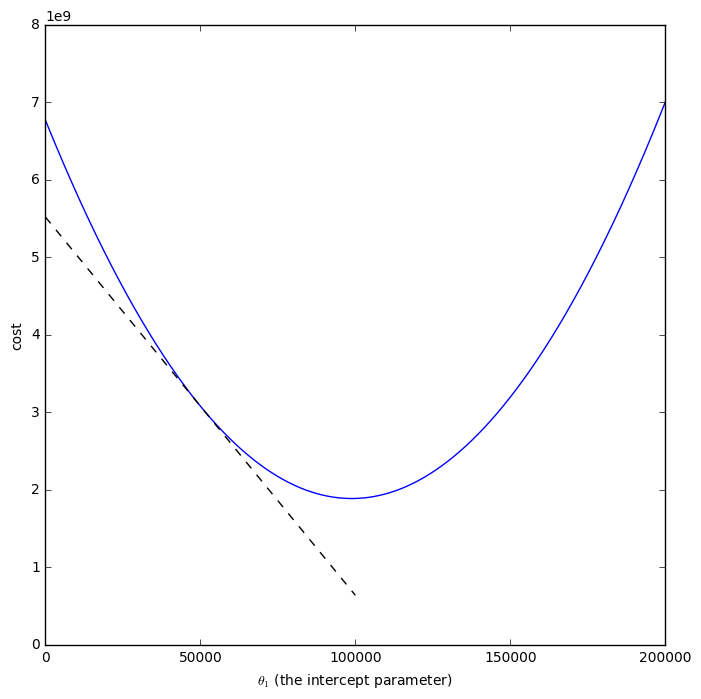

In [20]:
theta0 = 116.296798317
intercepts = np.linspace(0, 200000, 1000) # hypothesis for an intercept from 0 to 200000

costs = np.empty(intercepts.shape)

for i, theta1 in enumerate(intercepts):
    theta = (theta0, theta1)
    cost = cost_function(theta, x, y)
    costs[i] = cost
    
# visualize the resulting costs curve with respect to the intercept
plt.plot(intercepts, costs)
plt.xlabel('$\\theta_1$ (the intercept parameter)')
plt.ylabel('cost')

# the derivative of the cost with respect to the intercept, at some point
theta1 = 50000.0 # change this to see derivative/slope at a different location
dx = d_theta_1((theta0, theta1), x, y)
print "slope at point %f: %f" % (theta1, dx)

# draw line with that slope at the given point
cost = cost_function((theta0, theta1), x, y)
b = cost - (dx * theta1)
delta = 50000.0
x1 = theta1 - delta
y1 = (dx * x1) + b
x2 = theta1 + delta
y2 = (dx * x2) + b
plt.plot([x1, x2], [y1,y2], 'k--')
''

We could do the same thing for with respect to the $\theta_0$ parameter that governs the slope of our linear
hypothesis.  The main differences for the other parameter, is that the derivative with respect to the parameter
uses the value of the input feature (e.g. we multiply the input feature times the differences when we sum
them up, see the equation for the partial derivative).

## Implementing Gradient Descent

Lets modify our previous function that calculates the derivative to calculate the derivative according to
our equation for both of our parameters:

In [21]:
def d_theta(theta, x, y):
    """Return the derivative of the cost function with respect to both of the
    theta_0 and theta_1 parameter
    """
    m = len(x) # should be true that m == len(x) == len(y)
    
    # calculate the derivaties
    dx = np.zeros(theta.shape)
    for i in range(len(x)):
        hypothesis = theta[1] + theta[0] * x[i]
        dx[1] += (hypothesis - y[i]) # calclulate the sum of the differences for theta_1 parameter
        dx[0] += (hypothesis - y[i]) * x[i] # calcualte sum of differences times input for theta_0 parameter

    # turn into the average of the sums
    dx = dx / (float(m))
    return dx

If you are following the discussion to this point, you should realize that the derivatives of the $\theta$
parameters should be 0 at the place where we found the optimal best fit line for our data.  For example:

In [22]:
theta0 = 116.296798317
theta1 = 98823.07611906
theta = np.array([theta0, theta1])
dx = d_theta(theta, x, y)
print "derivate with respect to theta_1 (intercept): ", dx[1]
print "derivative with respect to theta_0 (slope): ", dx[0]

derivate with respect to theta_1 (intercept):  7.9357982386e-07
derivative with respect to theta_0 (slope):  0.00149551735305


So not exactly 0, but very small (it is not exactly 0 simply due to rounding differences and limits of
representation we can achieve with our floating point numbers).

Using this function that calculates the derivative with respect to our parameters, we can implement gradient
descent fairly simply for ourselves.  Using our previous pseudocode, gradient descent would be implemented
something like the following:


In [23]:
def gradient_descent(theta, x, y):
    """Implement gradient descent.  Given initial value of theta, iterate until convergence by calculating
    gradient of the function and taking small steps along the gradient.
    """
    # the following will only work well if we use separate learning rates, 
    # very small for the theta_0 slope (alpha_0 = 0.0000001)
    # and much larger for the the theta_1 intercept (alpha_1 = 0.1)
    alpha_0 = 0.0000001
    alpha_1 = 0.1
    print "Initial value of theta: ", theta
    for i in range(1000):
        dx = d_theta(theta, x, y)
        theta[0] = theta[0] - alpha_0 * dx[0]
        theta[1] = theta[1] - alpha_1 * dx[1]
        print dx
        print "At iteration %d: %f, %f" % (i, theta[0], theta[1])

In [24]:
theta = np.array([0.0, 0.0])
gradient_descent(theta, x, y)

Initial value of theta:  [ 0.  0.]
[ -5.60555013e+08  -3.03848659e+05]
At iteration 0: 56.055501, 30384.865854
[ -3.20773150e+08  -1.74640678e+05]
At iteration 1: 88.132816, 47848.933688
[ -1.83424897e+08  -1.00625869e+05]
At iteration 2: 106.475306, 57911.520573
[ -1.04751803e+08  -5.82263675e+04]
At iteration 3: 116.950486, 63734.157321
[ -5.96885189e+07  -3.39364989e+04]
At iteration 4: 122.919338, 67127.807206
[ -3.38773187e+07  -2.00200542e+04]
At iteration 5: 126.307070, 69129.812630
[ -1.90939291e+07  -1.20456428e+04]
At iteration 6: 128.216463, 70334.376910
[ -1.06273906e+07  -7.47491195e+03]
At iteration 7: 129.279202, 71081.868105
[ -5.77921028e+06  -4.85386364e+03]
At iteration 8: 129.857123, 71567.254468
[-3003660.11097228    -3349.63069365]
At iteration 9: 130.157489, 71902.217538
[-1415328.970837      -2485.13699872]
At iteration 10: 130.299022, 72150.731238
[-507043.06761071   -1987.10770533]
At iteration 11: 130.349726, 72349.442008
[ 11712.63352148  -1699.00771536]
At 

If you try the previous implementation of `gradient_descent()` with any learning rates other than hardcoded you will
most likely see an example of how the gradient descent algorithm can be unstable.  Basically if your step size
is too big, you will take a step over the minimum, to a location that is worse (higher cost) than before.  And
from there things will quickly loose control as the next step will be even worse, etc.  Thus if you ever
implement gradient descent and the answer diverges, it means you need to try a smaller learning rate.


In [25]:
x = house['size'].as_matrix() 
y = house['price'].as_matrix()
# scale the expected prices to be in 1000's of US$
y = y / 1000.0
print y

[ 399.9    329.9    369.     232.     299.9    314.9    198.999  212.
  242.5    239.999  347.     329.999  259.9    449.9    299.9    199.9
  499.998  252.9    255.     242.9    259.9    249.9    464.5    469.     475.
  299.9    349.9    169.9    314.9    285.9    249.9    229.9    345.     287.
  368.5    329.9    314.     299.     179.9    299.9    239.5  ]


''

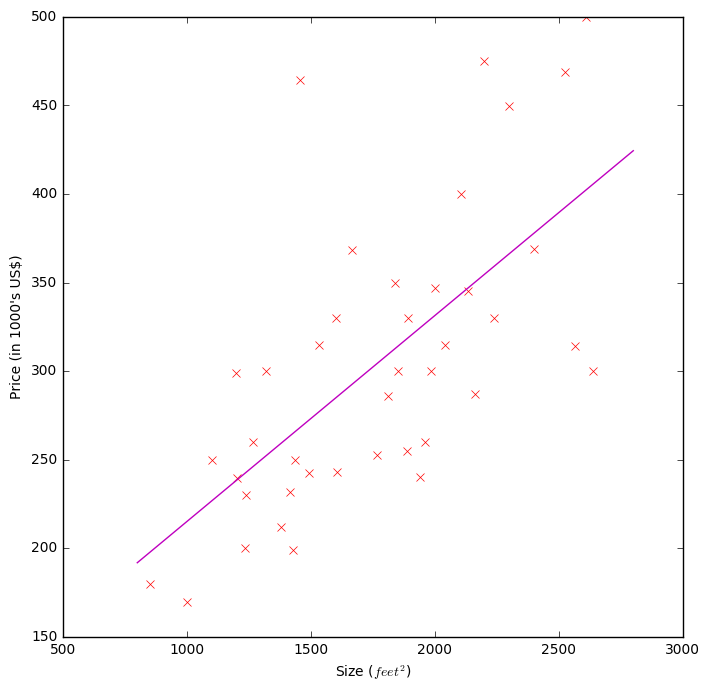

In [26]:
# replot raw data
plt.plot(x, y, 'rx')
plt.xlabel('Size ($feet^2$)')
plt.ylabel('Price (in 1000\'s US$)')
#plt.axis([-100, 3000, -5000, 500000])

#Overlay the fitted model
theta = np.polyfit(x, y, 1)
hypothesis = np.poly1d(theta)
size = np.linspace(800, 2800, 100)
plt.plot(size, hypothesis(size), 'm-')

''

Notice that this has the effect of scaling the intercept and the slope of our model (both by 1000)

In [27]:
print "slope: ", theta[0]
print "intercept: ", theta[1]

slope:  0.116296798317
intercept:  98.8230761191


# Normalizing Data to Deal With Learning Rate Problem

In real gradient descent implementations, we have to deal with the problem that you need different learning rate
increments for each parameter.  The correct learning rate will depend on the range and scale of the data for
the given input/parameter.  One way to deal with this is to first normalize all input dimensions so that they
for example have a mean value of 0.0 and a standard deviation of 1.0 in the data.  

The following cells show this method.  We first normalize the input (and outoput) data so it has
mean 0.0 and standard devation 1.0, before we perform gradient descent.  This allows us to use a single
learning rate parameter.  After gradient descen, we then have to unnormalize the resulting found
theta parameters.

The following needs some more discussion here.



In [28]:
def gradient_descent(theta, x, y):
    """Implement gradient descent.  Given initial value of theta, iterate until convergence by calculating
    gradient of the function and taking small steps along the gradient.
    """
    # the following will only work well if we use separate learning rates, 
    # very small for the theta_0 slope (alpha_0 = 0.0000001)
    # and much larger for the the theta_1 intercept (alpha_1 = 0.1)
    alpha_0 = 0.0000001
    alpha_1 = 0.1
    print "Initial value of theta: ", theta
    for i in range(1000):
        dx = d_theta(theta, x, y)
        theta[0] = theta[0] - alpha_0 * dx[0]
        theta[1] = theta[1] - alpha_1 * dx[1]
        print dx
        print "At interation %d: %f, %f" % (i, theta[0], theta[1])

In [29]:
theta = np.array([0.0, 0.0])
gradient_descent(theta, x, y)

Initial value of theta:  [ 0.  0.]
[ -5.60555013e+05  -3.03848659e+02]
At interation 0: 0.056056, 30.384866
[ -3.20773150e+05  -1.74640678e+02]
At interation 1: 0.088133, 47.848934
[ -1.83424897e+05  -1.00625869e+02]
At interation 2: 0.106475, 57.911521
[ -1.04751803e+05  -5.82263675e+01]
At interation 3: 0.116950, 63.734157
[ -5.96885189e+04  -3.39364989e+01]
At interation 4: 0.122919, 67.127807
[ -3.38773187e+04  -2.00200542e+01]
At interation 5: 0.126307, 69.129813
[ -1.90939291e+04  -1.20456428e+01]
At interation 6: 0.128216, 70.334377
[ -1.06273906e+04  -7.47491195e+00]
At interation 7: 0.129279, 71.081868
[ -5.77921028e+03  -4.85386364e+00]
At interation 8: 0.129857, 71.567254
[-3003.66011097    -3.34963069]
At interation 9: 0.130157, 71.902218
[-1415.32897084    -2.485137  ]
At interation 10: 0.130299, 72.150731
[-507.04306761   -1.98710771]
At interation 11: 0.130350, 72.349442
[ 11.71263352  -1.69900772]
At interation 12: 0.130349, 72.519343
[ 307.34850141   -1.53117182]
At in

In [30]:
print x.mean()
print x.std()
mean_x = x.mean()
std_x = x.std()
print np.mean((x - mean_x) / std_x)
print np.std((x - mean_x)/ std_x)

#print y.mean()
#print y.std()
mean_y = y.mean()


1762.95121951
462.574711235
-1.02898719356e-16
1.0


In [31]:
def normalize(v):
    """Normalize the values in v to have a mean of 0.0 and a std of 1.0
    """
    mean_v = np.mean(v)
    std_v = np.std(v)
    norm_v = (v - mean_v) / std_v
    return (mean_v, std_v, norm_v)

def unnormalize(theta, means, stds):
    """Given a set of theta calculated on normalized data, with given means and std,
    calculate the unnormalized theta parameters
    """
    # pick two points in the normalized hypothesis space
    x1 = -1.0
    y1 = theta[1] + theta[0] * x1
    x2 = 1.0
    y2 = theta[1] + theta[0] * x2
    
    # unnormalize the points to original coordinate space
    mean_x, mean_y = means
    std_x, std_y = stds
    x1 = (x1 * std_x) + mean_x
    y1 = (y1 * std_y) + mean_y
    x2 = (x2 * std_x) + mean_x
    y2 = (y2 * std_y) + mean_y
    
    # now calculate the theta parameters for the unnormalized points
    theta_new = np.zeros(2)
    theta_new[0] = (y2 - y1) / (x2 - x1) # slope
    theta_new[1] = y2 - theta_new[0] * x2 # intercept
    return theta_new
    
    
x = house['size'].as_matrix() 
y = house['price'].as_matrix()

mean_x, std_x, norm_x = normalize(x)
print mean_x, std_x
mean_y, std_y, norm_y = normalize(y)
print mean_y, std_y
print norm_x

1762.95121951 462.574711235
303848.658537 81618.0848762
[ 0.73728367 -0.35227006  1.3771803  -0.75004364  0.48002793 -0.49494971
 -0.7262637  -0.8278689  -0.58142223  0.38274635  0.51245512  0.2746557
 -1.06999195  1.16099901 -0.95757768 -1.13916997  1.82899921  0.00875271
  0.27033207 -0.3436228   0.43030623 -1.43317653 -0.65924749  1.64956873
  0.94481771  1.88952997  0.16440324 -1.64935782  0.59892764  0.10387248
 -0.70464557 -1.13268453  0.79781443  0.86266882 -0.21391403  1.0269666
  1.73820306 -1.21699524 -1.96930614  0.19250681 -1.2105098 ]


[  6.59118111e-01   3.64114183e-16]
852.0 197907.948285
2637.0 405497.73328
116.296798317 98823.0761191
[   116.29679832  98823.07611906]


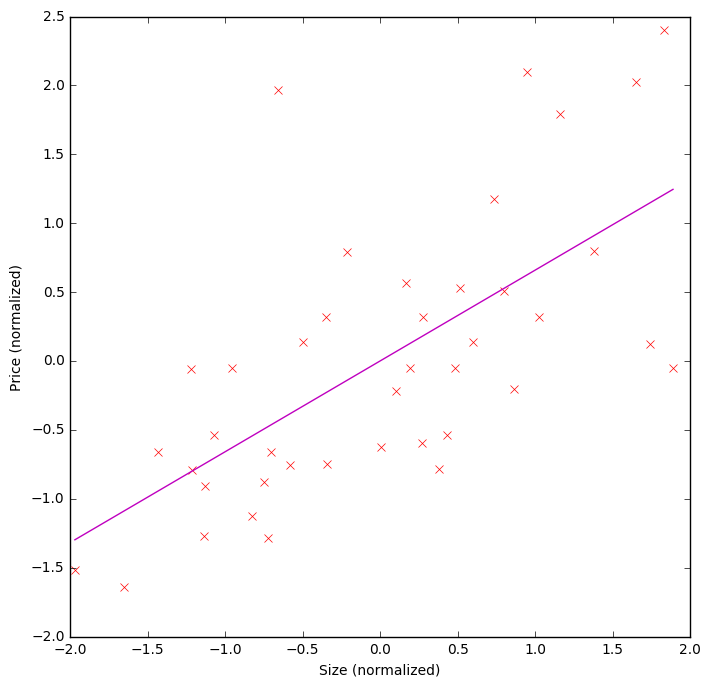

In [32]:
# replot raw data
plt.plot(norm_x, norm_y, 'rx')
plt.xlabel('Size (normalized)')
plt.ylabel('Price (normalized)')
#plt.axis([-100, 3000, -5000, 500000])

#Overlay the fitted model
theta = np.polyfit(norm_x, norm_y, 1)
hypothesis = np.poly1d(theta)
size = np.linspace(np.min(norm_x), np.max(norm_x), 100)
plt.plot(size, hypothesis(size), 'm-')
print theta

# algorithm to convert theta on the normed data back to theta parameter on original values
# first find 2 point in normed data
x1 = np.min(norm_x)
y1 = hypothesis(x1)
x2 = np.max(norm_x)
y2 = hypothesis(x2)

# now we convert both points back to original unnormed coordinates
x1 = (x1 * std_x) + mean_x
y1 = (y1 *std_y) + mean_y
print x1, y1
x2 = (x2 * std_x) + mean_x
y2 = (y2 *std_y) + mean_y
print x2, y2

# we can now recalculate the slope and intercept from these 2 points in original coordinates
theta_0 = (y2 - y1) / (x2 - x1) # slope
theta_1 = y2 - theta_0 * x2 # intercept
print theta_0, theta_1

print unnormalize(theta, (mean_x, mean_y), (std_x, std_y))

In [33]:
def gradient_descent_normed(theta, x, y, alpha=0.1):
    """Implement gradient descent.  Given initial value of theta, iterate until convergence by calculating
    gradient of the function and taking small steps along the gradient.  We first normalize the data, then
    perform the gradient descent, then unnormalize and return the result
    """
    mean_x, std_x, norm_x = normalize(x)
    mean_y, std_y, norm_y = normalize(y)
    print mean_x, mean_y, std_x, std_y
    
    theta_norm = unnormalize(theta, (mean_x, mean_y), (std_x, std_y))
    print "Initial value of theta: ", theta_norm
    for i in range(1000):
        dx = d_theta(theta, norm_x, norm_y)
        theta[0] = theta[0] - alpha * dx[0]
        theta[1] = theta[1] - alpha * dx[1]
        print dx
        theta_norm = unnormalize(theta, (mean_x, mean_y), (std_x, std_y))
        print "At iteration %d: %f, %f" % (i, theta_norm[0], theta_norm[1])
        
    return theta_norm # return the last calculated normalized theta parameters

In [34]:
theta = np.array([0.0, 0.0])
gradient_descent_normed(theta, x, y)

1762.95121951 303848.658537 462.574711235 81618.0848762
Initial value of theta:  [      0.          303848.65853659]
[ -6.59118111e-01  -3.35774768e-16]
At iteration 0: 11.629680, 283346.100295
[ -5.93206300e-01  -3.14111880e-16]
At iteration 1: 22.096392, 264893.797877
[ -5.33885670e-01  -2.59954659e-16]
At iteration 2: 31.516432, 248286.725701
[ -4.80497103e-01  -2.30168188e-16]
At iteration 3: 39.994469, 233340.360743
[ -4.32447392e-01  -2.19336744e-16]
At iteration 4: 47.624702, 219888.632281
[ -3.89202653e-01  -2.30168188e-16]
At iteration 5: 54.491912, 207782.076665
[ -3.50282388e-01  -1.99027786e-16]
At iteration 6: 60.672400, 196886.176610
[ -3.15254149e-01  -1.63825593e-16]
At iteration 7: 66.234840, 187079.866561
[ -2.83728734e-01  -1.51640218e-16]
At iteration 8: 71.241036, 178254.187517
[ -2.55355861e-01  -1.42162704e-16]
At iteration 9: 75.746612, 170311.076377
[ -2.29820275e-01  -1.36746982e-16]
At iteration 10: 79.801631, 163162.276351
[ -2.06838247e-01  -1.38100913e-16]

array([   116.29679832,  98823.07611906])

In [35]:
def gradient_descent_normed_v2(theta, x, y, alpha=0.2, accuracy=0.001):
    """Implement gradient descent.  Given initial value of theta, iterate until convergence by calculating
    gradient of the function and taking small steps along the gradient.  We first normalize the data, then
    perform the gradient descent, then unnormalize and return the result.
    
    This version implements convergence detection.  We stop iterating when all gradients are below the
    accuracy threshold.  This version also returns the complete history of the theta parameters as
    a list of (theta_0,theta_1) tuples.
    """
    mean_x, std_x, norm_x = normalize(x)
    mean_y, std_y, norm_y = normalize(y)
    theta_norm = unnormalize(theta, (mean_x, mean_y), (std_x, std_y))
    done = False
    history = []
    history.append(theta_norm)
    while not done:
        # find gradients
        dx = d_theta(theta, norm_x, norm_y)
        
        # take a step along gradients
        theta[0] = theta[0] - alpha * dx[0]
        theta[1] = theta[1] - alpha * dx[1]
        
        # keep track of history of gradient descent steps
        theta_norm = unnormalize(theta, (mean_x, mean_y), (std_x, std_y))
        history.append(theta_norm)
        
        # test if done
        if np.all(np.abs(dx) < accuracy):
            done = True
        
        
    return np.array(history) # return the history of gradient descent

In [36]:
theta = np.array([0.0, -3.72])
history = gradient_descent_normed_v2(theta, x, y)
print len(history)
print history[0,:]

39
[   0.          229.38279711]


''

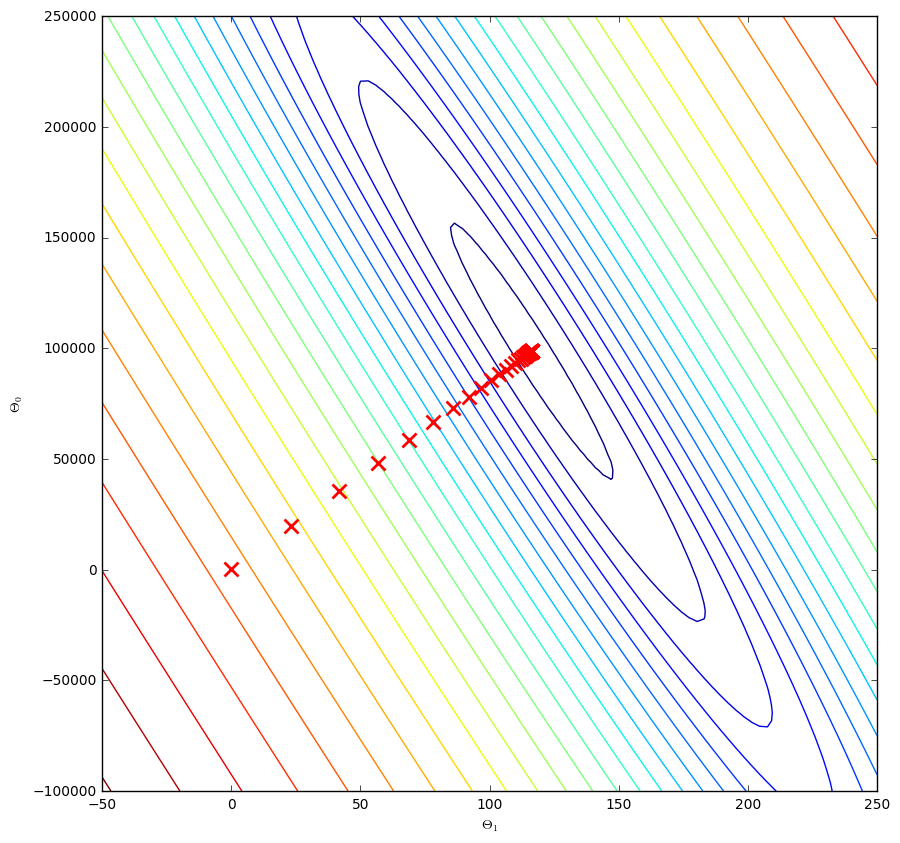

In [37]:
# set up figure
fig = plt.figure(figsize=(10,10))

### RIGHT subplot
# show contour plot of the cost function
t0 = np.linspace(-50.0, 250.0, 100) # slope values
t1 = np.linspace(-100000, 250000, 100) # intercept values
T0, T1 = np.meshgrid(t0, t1)
cost = cost_function_2(T0, T1, x, y)

p = plt.contour(T0, T1, np.log(np.log(cost)), 25, cmap=plt.cm.jet)

#cb = fig.colorbar(p, shrink=0.8) # uncomment if you want to see colorbar showing log value of the cost
plt.xlabel('$\Theta_1$')
plt.ylabel('$\Theta_0$')

# plot the location of theta0, theta1 on the contour plot
#plt.plot(theta0, theta1, 'rx', ms=10.0, mew=2.0)
#plt.title('$C(\Theta_0, \Theta_1)$ cost function')
plt.plot(history[:,0], history[:,1], 'rx', ms=10.0, mew=2.0)
''

# Multiple Features

So far our example training data has only had 1 input training feature, the size of the house.  This data 
did end up needing two parameters to be fitted, representing the slope and the intercept of the line we
fit to the data as our model of the relationship between size and cost of the house.

The technique that we looked at, and the equations we developed, for linear regression are completely
generalizable to as many input features as are available that we would like to fit.

Notationally, we had been simply using $x$ to denote the input, and $y$ to denote the output.  Now
that we have more features, we will need a bit of additional notation.  Recall that we used $x^{(i)}$
to denote the $i^{th}$ input and output training example.  However, now instead of having a single
feature (like size in square feet), we have $n$ number of features.  We will use the expanded notation:

**Notation:**

- $n = $ number of features
- $x^{(i)} = $ input (features) of the $i^{th}$ training example (this is a vector of length $n$ ).
- $x_j^{(i)} = $ value of particular feature $j$ in the $i^{th}$ training example.
- $m = $ number of training examples.
- $y^{(i)} = $ output of the $i^{th}$ training example.

Using `NumPy` array indexing, the first index will select the row, which corresponds to the input
pattern number $i$, and the second index will select the column, which corresponds to the feature
number $j$.  In the following expanded data set, each house now has 4 features: the size in
square feet (as before), the number of bedrooms, the number of floors in the house, and the age of the
house.  Here is an example:

In [38]:
house = pd.read_csv('data/housing-prices-4-features-portland-or.csv')
x = house.ix[:,0:4].as_matrix()
y = house.price.as_matrix()

print x.shape
print y.shape

(47, 4)
(47,)


In [39]:
# the first 4 training input patterns
print x[:4]

[[2104    3    1   45]
 [1600    3    2   40]
 [2400    3    2   30]
 [1416    2    1   36]]


In [40]:
# the input training pattern at index 3 (0 based indexing, so actually the 4th overall
print x[3]

[1416    2    1   36]


In [41]:
# feature 0 is the size, feature 1 is the number of bedrooms, feature 2 is number of floors,
# feature 3 is the age of the house
print "size (sq ft.) = ", x[3,0]
print "num bedrooms  = ", x[3,1]
print "num floors    = ", x[3,2]
print "age of house  = ", x[3,3]

size (sq ft.) =  1416
num bedrooms  =  2
num floors    =  1
age of house  =  36


In [42]:
x[:,3] # the age of all 47 houses in our data set

array([45, 40, 30, 36, 45, 30, 36, 25, 28, 15, 30, 22, 19,  5, 11, 17, 12,
       22, 40, 34, 35, 37, 39, 11,  6, 22, 25, 29, 33, 10, 19, 17, 15, 13,
       11,  4, 22, 25, 27, 33, 31, 30, 29, 30, 40, 45, 38])

What is the form of the hypothesis with more than 1 feature. For 4 features we would have:

$$h_\theta(x) = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \theta_3 x_3 + \theta_4 x_4$$

And in general, for $n$ features, we have $n + 1$ parameters:

$$h_\theta(x) = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + ... + \theta_n x_n$$

For convenience in programming, we usually think of the previous equation as having
an additional input $x_0 = 1$ that is always set to one.  In this way, we can define
$n + 1$ sized vectors to represent some particular set of input features, and another 
$n + 1$ sized vector to represent a set of $\theta$ hypothesis parameters:

$$
x =
\begin{bmatrix}
x_0 \\
x_1 \\
x_2 \\
\vdots \\
x_n \\
\end{bmatrix}
\in \mathbb{R}^{n+1}
\;\;\;
\theta =
\begin{bmatrix}
\theta_0 \\
\theta_1 \\
\theta_2 \\
\vdots \\
\theta_n \\
\end{bmatrix}
\in \mathbb{R}^{n+1}
$$

And a sort of a note: This is convenient for us using a 0 based indexing programming language like 
`NumPy` arrays, as we can use the $0^{th}$ index for the $x_0 = 1$ and the $\theta_0$ values corresponding
to the intercept parameter of our system.

Finally, the full form of our hypothesis for linear regression is:

$$h_\theta(x) = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + ... + \theta_n x_n$$

Using the transpose of the $\theta$ vector, we can use simple vector vector multiplication,
simplifying the hypothesis equation to be:

$$h_\theta(x) = \theta^T x$$

As an example, lets show how, given a set of 4 feature inputs, and a set of 4 hypothesis parameters,
we can get the hypothesis output using this simple vector vector multiplication:

In [43]:
# input for a house, x_0 is set to 1.0, and the house
# has 1416 square feet, 3 bedrooms, 2 floors and is 40 years old
x = np.array([[1.0], 
              [1416], 
              [3],
              [2], 
              [40]])

# We pick values for the 5 theta parameters we need for our hypothesized
# model
theta = np.array([[80],
                  [120.0],
                  [0.01],
                  [3],
                  [-2]])

# calculate the hypothesis in a single vector x vector
# multiplication
print np.dot(theta.T, x)

[[ 169926.03]]


This result basically represents the prices for the given set of inputs, and given
the current set of hypothesis parameters.  Notice that we have 4 input features, and the $x_0$ feature
is the dummy value $1.0$.

In [44]:
# an example then of using above matrix multiplication to generate all hypothesis
# for all inputs simultaneously
X = house.ix[:,0:4].as_matrix()
y = house.price.as_matrix()
m, n = X.shape # m = number of inputs, n = number of features

# need to add a column of 1's to the x matrix
print X.shape
print X[:3,:]

X_ones = np.ones((m, n+1))
X_ones[:, 1:] = X
np.set_printoptions(suppress=True)

print X_ones.shape
print X_ones[:3,:]

# note, in previous formula X were column vectors, so the features need to be in columns for the previous
# equation to work...
print X_ones[:3,:].T


(47, 4)
[[2104    3    1   45]
 [1600    3    2   40]
 [2400    3    2   30]]
(47, 5)
[[    1.  2104.     3.     1.    45.]
 [    1.  1600.     3.     2.    40.]
 [    1.  2400.     3.     2.    30.]]
[[    1.     1.     1.]
 [ 2104.  1600.  2400.]
 [    3.     3.     3.]
 [    1.     2.     2.]
 [   45.    40.    30.]]


In [45]:
# now perform the actual matrix multiplication to get the hypothesized house prices for all training inputs
theta = np.array([[80],
                  [120.0],
                  [0.01],
                  [3],
                  [-2]])

print theta.T.shape
print X_ones.T.shape
print np.dot(theta.T, X_ones.T)

(1, 5)
(5, 47)
[[ 252473.03  192006.03  288026.03  169931.02  359993.04  238226.04
   184091.03  171273.03  165630.03  179333.03  232823.04  240039.03
   226851.03  537433.05  152224.03  276049.04  158459.02  148362.03
   313083.04  363735.04  212053.03  226572.02  192485.03  235501.04
   466871.03  132042.03  174993.03  303145.03  264017.03  316509.03
   220725.02  120049.01  244856.04  376500.03  217381.04  172515.03
   148719.03  255873.04  505832.04  259457.04  199704.02  268586.03
   308065.04  144023.03  102243.02  222233.04  144370.03]]


# Gradient Descent for Multiple Variables

To summarize, here are our equations and notation for multivariate linear regression that
we are currently working with:

- **Hypothesis:** $h_\theta(x) = \theta^T x = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + ... + \theta_n x_n$
- **Parameters:** $\theta_0, \theta_1, \dots, \theta_n$
- **Cost function:**
$$C(\theta_0, \theta_1, \dots, \theta_n) = \frac{1}{2m} \sum_{i=1}^{m} \big( h_\theta(x^{(i)}) - y^{(i)} \big)^2$$
- **Gradient descent:**
`repeat` {
$$\theta_j := \theta_j - \alpha  \frac{\partial}{\partial \theta_j} C(\theta_0,..., \theta_n)$$
} (simultaneously update for every $j = 0, ..., n$

The cost function allows you to calculate the "cost", or how well a particular set of hypothesis
parameters $\theta$ does in modeling the data.  The lower the cost, the better the parameters are at
fitting the data.  The cost function sums differences squared between the hypothes model output
and the actual output.

The gradient descent algorithm is an algorithm we can use to find the values of the $\theta$ parameters
that give the best, or minimum cost, when fitting to the data.  When we were looking at 1 variable
last week, we only had two theta parameters.  For the multivariate case, we have to simultaneously
update the $n + 1$ $\theta$ parameters, but this extension to the basic idea is straight forward.

## Gradient Descent update Equations

The general form for the derivative of our cost function, with respect to each feature is given by:

$$
\frac{\partial C(\theta)}{\partial \theta_j} =  \frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)}) x_j^{(i)}
$$

The generalized case then for mutivariate gradient descent looks like the following.  This equation
basically has determined the partial derivative of the $J()$ cost function with respect to each
variable:


`repeat` {
$$\theta_j := \theta_j - \alpha  \frac{1}{m} \sum_{i=1}^m \big(h_\theta(x^{(i)}) - y^{(i)} \big) x_j^{(i)} $$
} (simultaneously update for every $j = 0, ..., n$


Two things to note about this form for our gradient descent algorithm:

1. $x_0$ will always be 1 by definition, so this form reduces to the form we gave in the univariate 
   case.
2. The partial derivative becomes the result of a summation of the difference between the
   hypothesis output and the actual output (divided by $m$, so you get an average over all
   $m$ input patterns), multiplied by the particular value of the feature for each pattern.  The
   only thing that differs in each case is the particular feature, which is a result of taking
   the partial derivative with respect to that feature.
   

# Advanced Optimization

Gradient descent is the simplest iterative optimization method, and is relatively easy to understand and program.
There are many other more advanced iterative optimization techniques.  These advanced optimization techniques
include Conjugate gradient, BFGS, and L-BFGS.  How these methods work is beyond the scope of this
course.  However, there are standard implementations of these more advanced optimization methods
available in the SciPy and SciKitLearn libraries.  Understanding what the cost function is, and how
to specify the partial derivative of the cost function, is important, because all of these libraries ask
you to create a function that implements the cost function and/or derivative term, and then implement
the optimization method for you.

Advanced optimization methods often have many advantages over gradient descent.  They usually don't have a learning rate parameter, they instead pick and adjust learning rate parameters automatically, as part of
the optimization algorithm.  Also, advanced optimization methods are often faster than gradient descent.
But these properties come at a cost of complexity of the algorithms, and they are much harder to
understand and implement.

We normally would not implement these advanced optimization methods by hand, 
just as we wouldn't normally write our own function to calculate square roots or sines of numbers.
There are Python libraries that implement these advanced optimizaiton methods.
Next we show the equivalent of writing cost functions and using the SciPy Optimization
library implementation to optimize our linear regression classification problem with multiple features.

First of all, we need functions that will calculate the cost and the partial derivatives with
respect to the features for our linear regression model.  We will use the cost and gradient
function expressions we developed above, and implement them here as Python functions:


In [46]:
def compute_regression_cost(theta, X, y):
    """Compute the cost function for linear regression.  
    
    Given a set of inputs X (we assume that the first column has been 
    initialized to 1's for the theta_0 parameter), and the correct 
    outputs for these inputs y, calculate the linear regression cost
    for the given input/outputs as defined by the theta parameters.
    
    Args
    ----
    theta (numpy nx1 array) - An array of the set of theta parameters
       to evaluate
    X (numpy mxn array) - The example inputs, first column is expected
       to be all 1's.
    y (numpy m size array) - A vector of the correct outputs of length m
       
    Returns
    -------
    C (float) - The sum squared difference cost function for the given
       theta parameters
    """
    
    # determine the number of training examples from the size of the correct outputs
    m = len(y)
    
    # calculate the hypothesis for the given theta
    hypothesis = np.dot(theta.T, X.T)
    
    # calculate the sum squared difference
    cost = np.sum( (hypothesis - y)**2.0 )
    
    # convert to the average of the cost
    cost = cost / (2.0 * m) 
    
    # return the calculated cost 
    return cost
                          

In [47]:
theta = np.array([[80],
                  [120.0],
                  [0.01],
                  [3],
                  [-2]])

print compute_regression_cost(theta, X_ones, y)

7153397958.28


In [48]:
def compute_regression_cost_gradients(theta, X, y):
    """Compute the gradients of the theta parameters for our linear regression
    cost function.
    
    Given a set of inputs X (we assume that the first column has been 
    initialized to 1's for the theta_0 parameter), and the correct 
    outputs for these inputs y, calculate the gradient of the cost function
    with respect to each of the theta parameters.
    
    Args
    ----
    theta (numpy nx1 array) - An array of the set of theta parameters
       to evaluate
    X (numpy mxn array) - The example inputs, first column is expected
       to be all 1's.
    y (numpy m size array) - A vector of the correct outputs of length m
       
    Returns
    -------
    gradients - A numpy n sized vector of the computed gradients.
    """

    # determine the number of training examples from the size of the correct outputs
    # and the number of parameters from the size of theta
    m = len(y)
    n = len(theta)
    
    # You need to return the following variable with the correctly calculated
    # gradients of theta
    gradients = np.zeros(n)

    # calculate the hypothesis for the given theta
    hypothesis = np.dot(theta.T, X.T)

    # calculate the individual gradients
    for j in range(n):
        gradients[j] = np.dot(hypothesis - y, X[:,j])
    
    # take average 
    gradients = gradients / m
    
    # return the numpy n sized vector of gradients
    return gradients

In [49]:
print compute_regression_cost_gradients(theta, X_ones, y)

[ -1.00298607e+05  -2.09640972e+08  -3.19382107e+05  -1.31093106e+05
  -2.66485569e+06]


Given these functions, we can use 
`scipy` [optimization methods](https://docs.scipy.org/doc/scipy-0.18.1/reference/optimize.html)
( [Wikipedia Optimization](https://en.wikipedia.org/wiki/Mathematical_optimization) )
to perform an optimization to find the  minimum $\theta$ parameters for us:

In [50]:
from scipy.optimize import minimize
theta = np.zeros( n+1 ) # initial theta parameters to start gradient descent from
res = minimize(compute_regression_cost, theta, method='BFGS', jac=compute_regression_cost_gradients, 
               args=(X_ones, y), options={'disp': True})
print res.x # res is n object, the x variable in res has the optimized parameters

Optimization terminated successfully.
         Current function value: 1915728460.978760
         Iterations: 17
         Function evaluations: 20
         Gradient evaluations: 20
[ 112433.64036736     142.92670094  -12493.21807483  -24619.84566283
     605.18047719]


Just as a double check, lets use the `curve_fit()` function from the `scipy.optimize` library to see if we get the 
same result.  The `np.polyfit` function can only be used to fit a polynomial to data with 1 feature, so the
`curve_fit()` function is needed here. For example, in our case we are going to be fitting a hyperplane to a set
of data with 4 dimensions, so we first of all define a function to calculate the hypothesized house cost given
some set of $\theta$ parameters:

In [51]:
def hypothesis(X, theta0, theta1, theta2, theta3, theta4):
    """Compute linear hypothesis on matrix of X inputs for the set of theta parameters. 
    X should be a mxn shaped numpy array representing m inputs with n distinct features.  This
    function assumes that there are m rows of inputs, and n columns of features, and that the 0th
    feature is a dummy feature of 1.0 representing the intercept or bias term of the model.
    
    theta should be an n shaped vector of values which represent the theta parameters of the
    hypothesized linear model.
    
    This function returns an m shaped vector of results, which are the hypothesized values for each
    of the m inputs in the X input data"""
    theta = np.array([theta0, theta1, theta2, theta3, theta4])
    return np.dot(theta.T, X.T)

The `curve_fit()` function by defaults uses the least squared cost function, so if we fit a curve to our
multidimensional data using our linear hypothesis model function, we should get about the same resulting theta
parameters that we found above using our own functions and the `scipy` `minimize` function:

In [52]:
from scipy.optimize import curve_fit

theta, cov = curve_fit(hypothesis, X_ones, y)
print theta

[ 112433.63472202     142.92670168  -12493.21778057  -24619.84486171
     605.18055373]


# Normal Equation

The normal equation is basically an analytical solution to solve for the optimal $\theta$ parameters.
It has some advantages and disadvantages over using the gradient descent algorithm.  Here is the
normal equation:

$$
\theta = (X^T X)^{-1} X^T y
$$


In [53]:
# these lines implement (X^T X)^-1 X^T y
# this is the Normal Equation, the values given for Theta are the minimum
# fitted parameters for the given data
Tmp = np.linalg.inv(np.dot(X_ones.T, X_ones))
Theta = np.dot(np.dot(Tmp, X_ones.T), y)
print Theta

[ 112433.64034843     142.92670094  -12493.21807433  -24619.84565825
     605.18047739]


Notice we get the same solution we find using the BFGS optimization method.

This method is basically the same as solving a series of simultaneous equations, where you set each
equation to 0.  

What are the advantages of and disadvantates of gradient descent vs. solving analytically using the
normal equation?

Gradient descent requires you to figure out a good $\alpha$ learning rate, and can require many iterations
to converge (so might take some time).  The normal equation does not have any parameter like the learning
rate that you have to figure out, and it does not require any iterations.

However, the need to compute the inverse of a matrix is itself a very time costly algorithm for a computer, so for very large numbers of features, inverting the matrix might end up taking much longer
than gradient descent.  So gradient descent works well, even if you have very large numbers of features.
Thus for Big Data problems, that can have thousands or millions of features, you almost always use some 
advanced iterative optimization method.

# Classification

In the past 2 weeks we were looking at what were known as regression problems, and trying to build a model
using linear regression.  I always think of a regression problem as simply trying to find a function that
maps a set of inputs, into a real valued, continuous output.  For example, for all practical purposes we
could consider the price of a house that we were trying to predict as a real valued number.  The selling
price of the house could take on any real value from 1000's of dollars to many millions of dollars, and
any real value in between these 2 extremes.  The task of linear regression was to take 1 or more input 
features, and determine a hypothesis, or model or map, that best fit
any particular input to a predicted house price.

Now we will be transitioning to a slightly different task, that of classification.  The main
difference when we are trying to build a model for a classification problem, is that the thing we are
trying to predict is no longer some real valued continuous property, but instead we are trying to predict
which class among a small but discrete set of possible classes some thing will belong to given a set
of input features.  Some examples of classification tasks include:

- Email: Spam / Not Spam?
- Online Transactions: Fradulent / Valid?
- Tumor: Malignant / Benign?

In all of these problems, we can think of the variable that we are trying to predict as taking on one of
two discrete possibilities:

$$
y \in \{0, 1\} \quad
\begin{cases}
    0: & \displaystyle \text{"Negative Class" (e.g. benign tumor)} \\
    1: & \text{"Positive Class" (e.g. malignant tumor)} \\
\end{cases}
$$

We will start with classification problems that only have 2 classes.  However, it is perfectly
acceptable and easy to extend the basic algorithms we will work on to problems with 3 or more
classes.

## Linear Regression vs. Logistic Regression to Perform Classification

You can make up examples where using linear regression would appear to work for a classification task.
However, in general, except for special situations, linear regression is not going to work.

Instead, logistic regression was developed to address classification problems. Logistic regression is
probably badly named, but for historical reasons the term stuck.  A better name might be logistic 
classification.  One property of logistic regression is that the algorithm will be developed in such
a way so that the hypothesis we get is always a value between 0 and 1:

$$
0 \le h_{\theta}(x) \le 1
$$

We then usually choose some threshold, say $\text{threshold} = 0.5$, and all
values less than the threshold are classified as the 0 or "Negative Class" and all those above the
threshold will be classified as 1 or the "Positive Class".

# Hypothesis Representation

What is the function we are going to use to represent our hypothesis for a classification problem?  We 
would like our hypothesis to have the property that it is always constrained to be between 0 and 1.

For logistic regression, we modify the linear regression hypothesis to pass it through what is known
as the logistic function $g(z)$.  Thus our hypothesis function becomes:

$$
h_{\theta}(x) = g(\theta^T x)
$$

Where we define the logistic function to be:

$$
g(z) = \frac{1}{1 + e^{-z}}
$$

This logistic function is also known as the sigmoid function, because of the shape the function makes 
looks like lazy s:

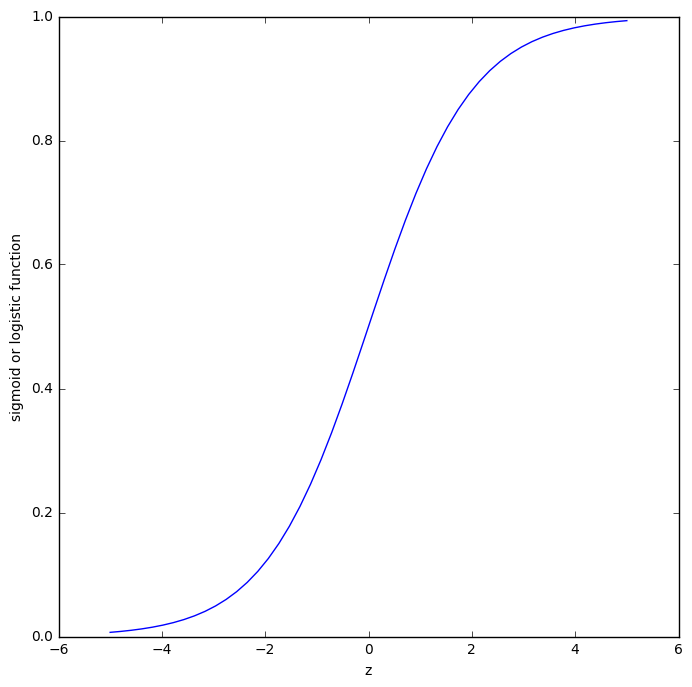

In [54]:
z = np.linspace(-5, 5, 50)

def g(z):
    return 1.0 / (1.0 + np.exp(-z))

plt.plot(z, g(z))
plt.xlabel('z')
plt.ylabel('sigmoid or logistic function')

Notice that the output of the function is always between 0 and 1.  The more negative of a number you
give to the function, the closer to 0 the output is, and the more positive, the closer the function
approaches to 1.  The function has a value of 0.5 when $z = 0$.  Thus if we use 0.5 as a threshold, then
an input that is less than 0 will be classified as 0, the negative class, and any input that is greater
than 0 will be classified as 1, the positive class.  However, note that the actual output, before we
threshold the result, is a real valued hypothesis such that $0 \le h_{\theta}(x) \le 1$.

**Interpretation of Hypothesis Output**

One interpretation of the hypothesis is that it is a measure of the estimated probability that
$y = 1$ given input x.  So for example if the hypothesis has an output of 0.7, you might interpret
that as a 70% chance that the positive class is true.  If we want to state what the probability
is for the negative class, we have to use $1 - h_{\theta}(x)$, so the probability of the previous
that it is the negative class is 30%.

# Decision Boundary

Suppose we set the threshold at $h_\theta(x) \ge 0.5$ to predict $y = 1$.  When is it exactly that
$h_\theta(x)$ will be above the threshold so that we will predict 1.  This of course happens when
$g(z) \ge 0.5$ which means that we will predict 1 when $\theta^Tx \ge 0$ and we will predict 0 when this
is less than 0.  

The boundary where the $\theta^Tx$ crosses over from negative to positive is the **decision boundary**
that our model creates.  The location of the decision boundary is of course a function of the $\theta$
parameter values.  The decision boundry will be a line or a hyperplane, depending on the number of 
input parameters we are dealing with in our problem.

A small made up example will illustrate this.  Lets say
we have the following input training values $x_1, x_2$ and the output vlaues $y$

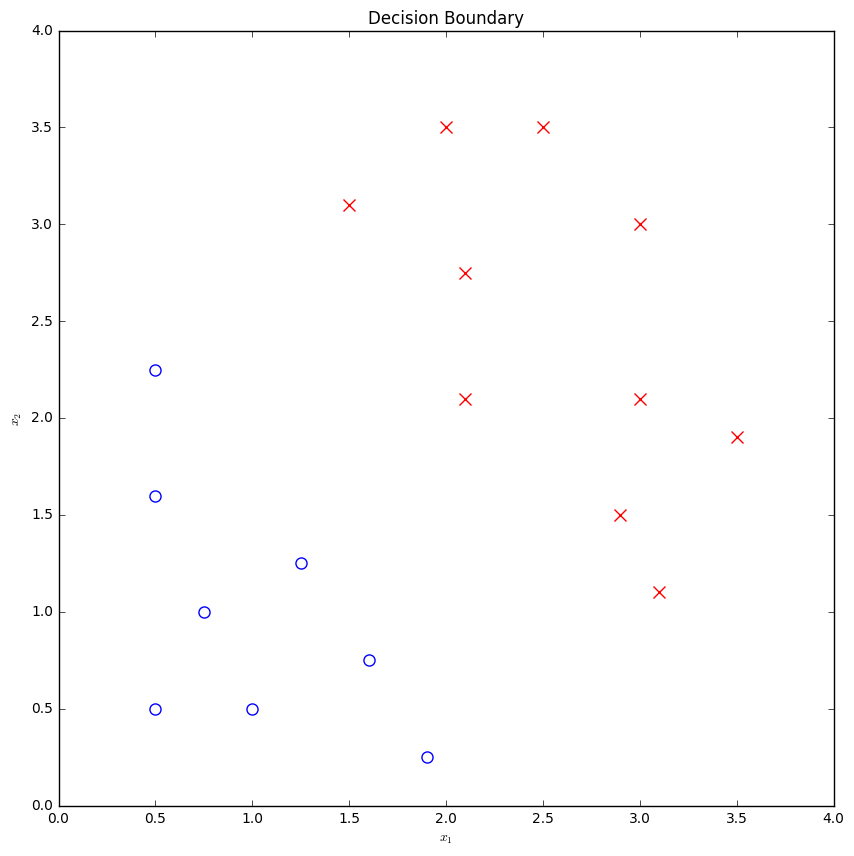

In [55]:
X = np.array([[0.5, 0.5],
              [1.0, 0.5],
              [0.75, 1.0],
              [1.9, 0.25],
              [1.6, 0.75],
              [1.25, 1.25],
              [0.5, 1.6],
              [0.5, 2.25],
              [3.1, 1.1],
              [2.9, 1.5],
              [2.1, 2.1],
              [2.1, 2.75],
              [1.5, 3.1],
              [3.5, 1.9],
              [3.0, 2.1],
              [3.0, 3.0],
              [2.0, 3.5],
              [2.5, 3.5]])
y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

neg_idx = np.where(y == 0)
pos_idx = np.where(y == 1)

# plot the example figure
plt.figure(figsize=(10,10))

# plot the points in our two categories, y=0 and y=1, using markers to indicated
# the category or output
plt.plot(X[neg_idx,0], X[neg_idx,1], 'bo', markersize=8, fillstyle='none', markeredgewidth=1) 
plt.plot(X[pos_idx,0], X[pos_idx,1], 'rx', markersize=8, markeredgewidth=1) 

# add some labels and titles
plt.axis([0, 4, 0, 4])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Decision Boundary')

Let us suppose that we have the hypothesis:

$h_\theta(x) = g(\theta_0 + \theta_1 x_1 + \theta_2 x_2)$

and that we have determined the following values for $\theta$:

$\theta_0 = -3, \theta_1 = 1, \theta_2 = 1$

We wil predict $y = 1$ if $-3 + x_1 + x_2 \ge 0$

The equation:

$x_1 + x_2 = 3$

is the decision boundary of this particular set of $\theta$ parameters.  This is the equation of a straight line, that passes through $(0, 3)$ and $(3, 0)$:

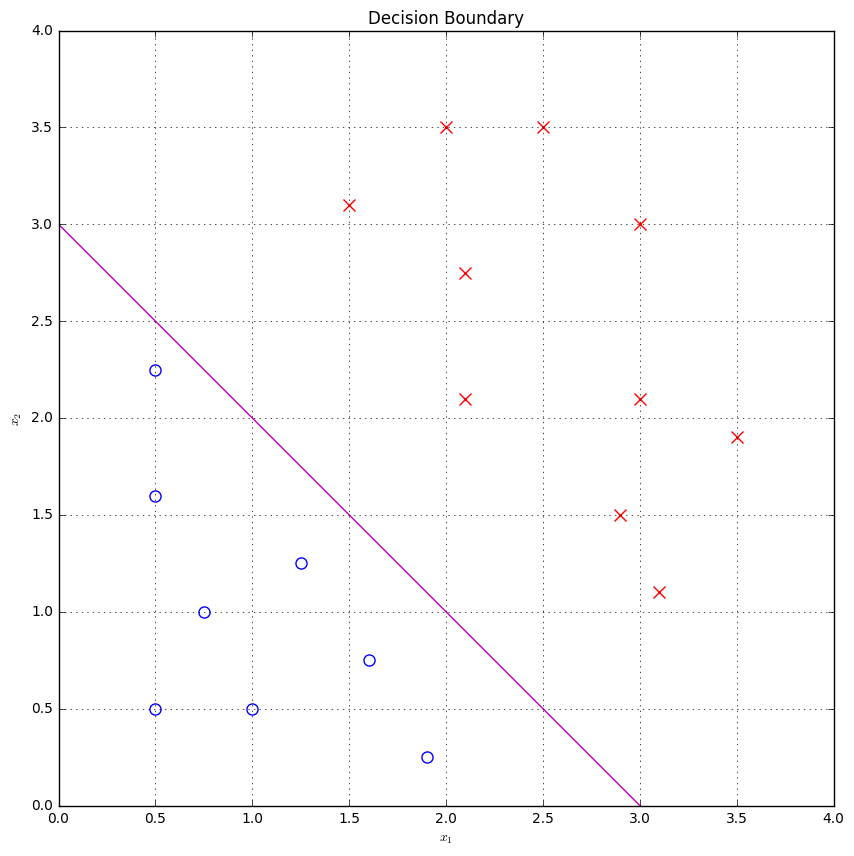

In [56]:
plt.figure(figsize=(10,10))

# plot the points in our two categories, y=0 and y=1, using markers to indicated
# the category or output
plt.plot(X[neg_idx,0], X[neg_idx,1], 'bo', markersize=8, fillstyle='none', markeredgewidth=1) 
plt.plot(X[pos_idx,0], X[pos_idx,1], 'rx', markersize=8, markeredgewidth=1) 

# plot the line x_1 + x_2 = 3
x1 = np.array([0, 3])
x2 = np.array([3, 0])
plt.plot(x1, x2, 'm-')

# add some labels and titles
plt.axis([0, 4, 0, 4])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Decision Boundary')
plt.grid()

If  you check, you will see any $x_1, x_2$ pair that is to the right or above the magenta line
(or on it) will have a value $ \ge 3$, and those below and to the left are less than $3$.  Conversely,
after running any pair of $x_1, x_2$ through our logistic function, all those points above and to the
right will have a value greater than the $0.5$ threshold, and those to the left and below will be less
than the threshold.

**Higher Order Polynomial Terms**

We talked briefly about non-linear terms when doing regression before, and we can use non-linear terms to define a decision boundary for logistic regression as well.  For example, instead of simply using 
linear terms of $x_1$ and $x_2$, we could also use polynomial terms like $x_1^2$ and $x_2^2$ in our
hypothesis:

$h_\theta(x) = g(\theta_0 + \theta_1 x_1 + \theta_2 x_2 + \theta_3 x_1^2 + \theta_4 x_2^2)$

If we use the following values for our $\theta$ parameters 
$\theta_0 = -1, \theta_1 = 0, \theta_2 = 0, \theta_3 = 1, \theta_4 = 1$ then we end up with the
equation:

$x_1^2 + x_2^2 = 1$

controlling the decision boundary.  This is of course the equation of a circle of radius 1 centered
on the origin:


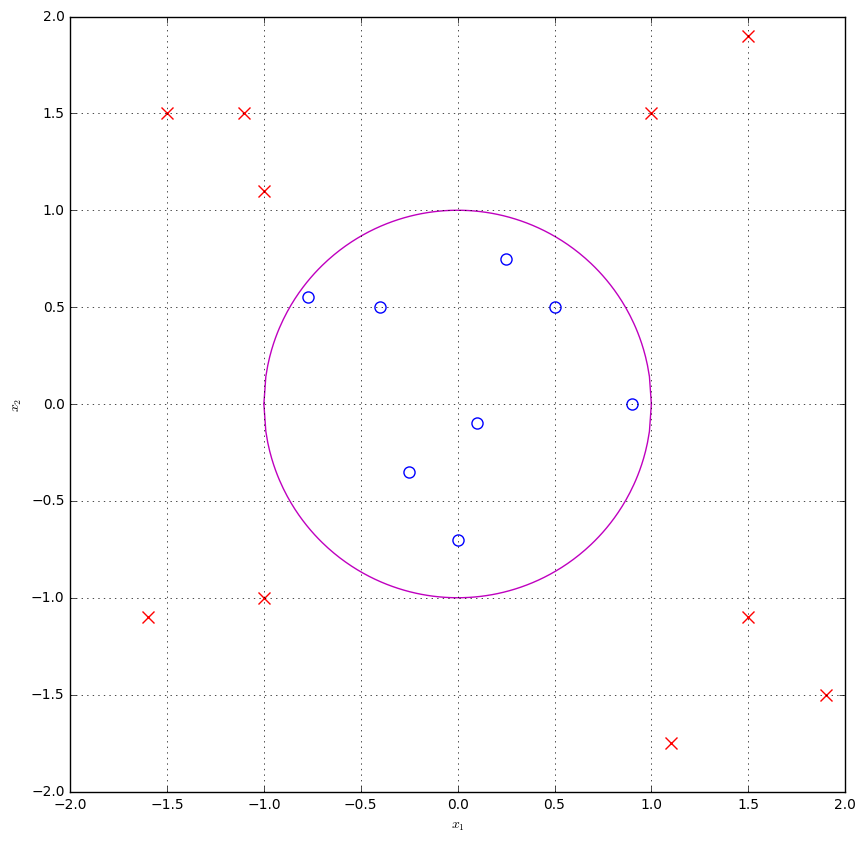

In [57]:
X = np.array([[0.5, 0.5],
              [0.9, 0.0],
              [0.0, -0.7],
              [-0.25, -0.35],
              [-0.4, 0.5],
              [-0.77, 0.55],
              [0.25, 0.75],
              [0.1, -0.1],
              
              [-1.1, 1.5],
              [1.9, -1.5],
              [-1.6, -1.1],
              [1.1, -1.75],
              [1.5, -1.1],
              [1.5, 1.9],
              [-1.0, 1.1],
              [-1.0, -1.0],
              [1.0, 1.5],
              [-1.5, 1.5]])

y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

neg_idx = np.where(y == 0)
pos_idx = np.where(y == 1)

# create points on decision bounadry, x_2 = +/- sqrt(1 - x_1^2)
x1 = np.linspace(-1.0, 1.0, 200)
x2pos = np.sqrt(1 - x1**2.0)
x2neg = -np.sqrt(1 - x1**2.0)

# plot the points in our two categories, y=0 and y=1, using markers to indicated
# the category or output
plt.figure(figsize=(10,10))
plt.plot(X[neg_idx,0], X[neg_idx,1], 'bo', markersize=8, fillstyle='none', markeredgewidth=1) 
plt.plot(X[pos_idx,0], X[pos_idx,1], 'rx', markersize=8, markeredgewidth=1) 


# plot the circle
plt.plot(x1, x2pos, 'm-')
plt.plot(x1, x2neg, 'm-')

# add labels and titles
plt.axis([-2, 2, -2, 2])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.grid()

Points inside of the circle, given the $\theta$ parameters, will be less than 0, and thus will be
categorized as the 0 category given the logistic function, and those points outside of the circle will
be categorized as the 1 category.

## Cost Function

**Summary of our Logistic Classification Problem**

Recall that we have a training set of $m$ examples: 

**Traing Set:** $\{ (x^{(1)}, y^{(1)}), (x^{(2)}, y^{(2)}), \ldots, (x^{(m)}, y^{(m)}),  \}$

The notation $x^{(1)}$ does not refer to exponentation here.  This notation simply means we have
a set of $m$  training data, where input 1 $x$ has a correct classification denoted by $y^{(1)}$
and we have input and output example 2, 3 up to example $m$.

Each input can consist of 1 or more features:

**m examples:** 

$$
x \in
\begin{bmatrix}
x_0 \\ 
x_1 \\ 
\ldots \\ 
x_n \\ 
\end{bmatrix}
x_0 = 1, y \in \{0, 1\}
$$

Remember by convention if we have $n$ actual features, we use $n+1$ input values in our equations, and
we set feature $x_0 = 1$.  At this point we are only talking about logistic classification of
problems with two categories, thus $y \in \{0, 1\}$.  We will later discuss classification problems
that have more than 2 categories.

Finally we run our hypothesis through the logistic function to get a value between 0.0 and 1.0 which we
can use as an estimate of the probability that our hypothesis is predicting the inputs should be in
the 1 category:

$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

The big question then is, how do we choose the $\theta$ parameters so that we end up with a good
hypothesis that maximizes our ability to correctly predict the categories of future data?

**Cost Function**

Recall that for linear regression, we were basically using a cost function that looked somthing like

$$
\textrm{Cost}(h_\theta(x), y) = \frac{1}{2} \big( h_\theta(x) - y \big)^2
$$

That is to say, the cost of one particular input, given a current hypothesis, is simply the
square of the difference between our prediction and the actual output (times 1/2).  Also recall that
for our gradient descent, to get the total cost we simply summed up this squared difference over all
of our training inputs for a given hypothesis.

Unfortunately, when we are trying to do logistic regression, remember that the hypothesis function
is now run through the logistic function before getting the final result.
This makes the cost function into a non-convex function, which would cause problems for our
gradient descent algorithm, since there are now many local minima, and we would thus have problems
to determine if we are at the global minimum or not.

So instead, we have to use a completely different cost function for Logistic Regression:

$$
\textrm{Cost}(h_\theta(x), y) = 
\begin{cases}
    -log(h_\theta(x)) & \displaystyle \text{if} \quad y = 1 \\
    -log(1 - h_\theta(x)) & \text{if} \quad y = 0 \\
\end{cases}
$$

We now plot this cost function for the two cases.  Recall that we know that the
hypothesis for our logistic regression, since it is put through the logistic function, will always
be a value between 0 and 1.  Thus we can see what the cost function will look like easily enough:

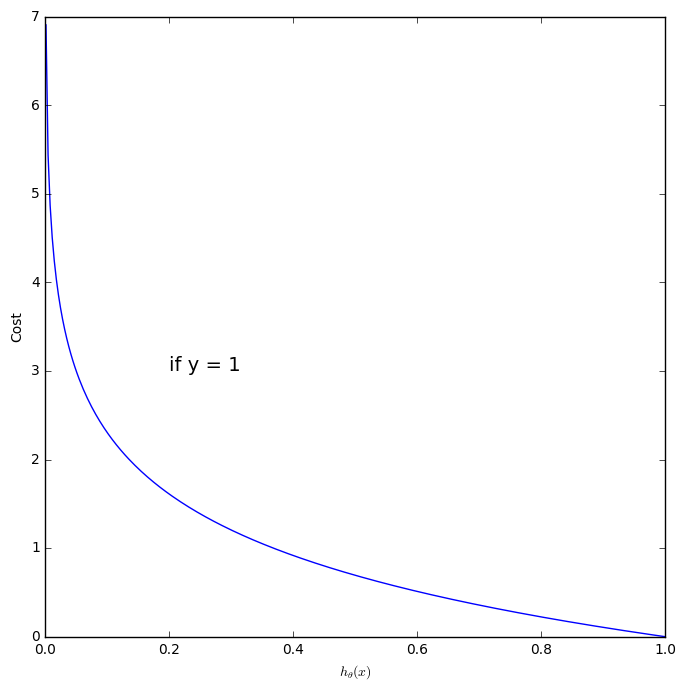

In [58]:
hypothesis = np.linspace(0.001, 1.0, 300)
cost = -np.log(hypothesis)

plt.plot(hypothesis, cost, 'b-')
plt.xlabel(r'$h_\theta(x)$')
plt.text(0.2, 3, r'if y = 1', fontsize=14)
plt.ylabel(r'Cost')

Notice that for the case where the correct output is 1, the cost goes to 0 as the hypothesis approaches
the correct cost.  On the other hand, the cost rapidly goes towards $\infty$ as the hypothesis 
approaches 0 when the correct output is 1. (In fact the logarithm is not defined at 0, so we have to
be careful with this cost function, if we ever have a hypothesis that is actually 0 we might get
nonsensical results).

The situation is similar for the case where the correct output is 0, but we of course have a cost of
0 when our hypothesis is 0, close to the correct answer, and it rapidly approaches $\infty$ as the
hypothesis approaches the incorrect conclusion of 1.

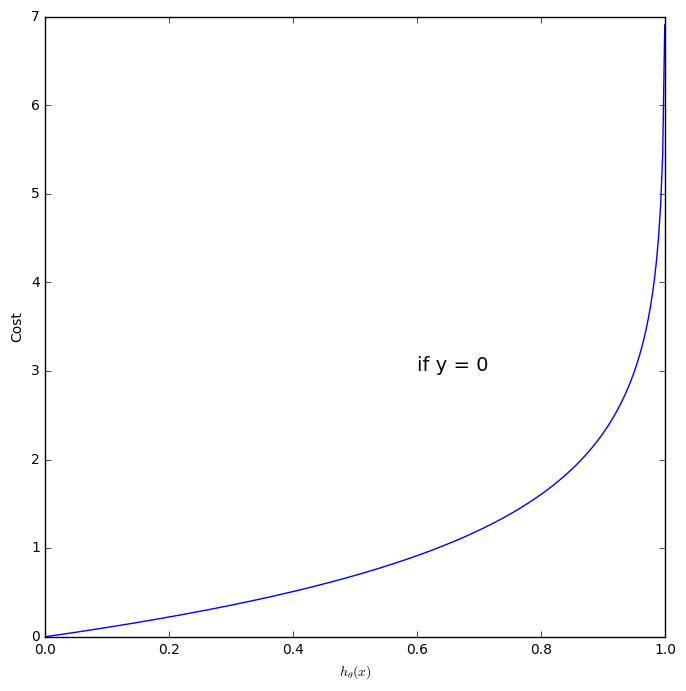

In [59]:
hypothesis = np.linspace(0.0, 0.999, 300)
cost = -np.log(1.0 - hypothesis)

plt.plot(hypothesis, cost, 'b-')
plt.xlabel(r'$h_\theta(x)$')
plt.text(0.6, 3, r'if y = 0', fontsize=14)
plt.ylabel(r'Cost')

## Simplified Cost Function and Gradient Descent

To summarize again so far:

**Logistic Regression cost function**

$$
C(\theta) = \frac{1}{m} \sum_{i=1}^m \textrm{Cost}(h_\theta(x^{(i)}), y^{(i)})
$$

$$
\textrm{Cost}(h_\theta(x), y) = 
\begin{cases}
    -log(h_\theta(x)) & \displaystyle \text{if} \quad y = 1 \\
    -log(1 - h_\theta(x)) & \text{if} \quad y = 0 \\
\end{cases}
$$

Note: $y = 0$ or $1$ always, we are still only talking about logistic regression with two categories.

We can specify the cost function in an alternative form, so that we don't have to have a condition 
statement in our code to implement it:

$$
\textrm{Cost}(h_\theta(x), y) = -y \; \textrm{log} (h_\theta(x)) - (1 - y) \; \textrm{log} (1 - h_\theta(x))
$$

This cost function is actually convex, so gradient descent will again work just fine if we use this
alternative cost function for logistic regression classification problems.  To fit the parameters
$\theta$, we want to find the parameters such that they minimize the cost function $C(\theta)$,
which is summed over all of our input/output training examples.

So our gradient descent for logistic regression looks like the following:

**Gradient Descent**

$$
C(\theta) = -\frac{1}{m} \big[ \sum_{i=1}^m  y^{(i)} \; \textrm{log} (h_\theta(x^{(i)})) + (1 - y^{(i)}) \; \textrm{log} (1 - h_\theta(x^{(i)})) \big]
$$

Want $\textrm{min}_\theta \; C(\theta)$:

Repeat {
$$
\theta_j := \theta_j - \alpha \frac{\partial}{\partial \theta_j} C(\theta)
$$
}

where we simultaneously update all of the $\theta_j$ parameters.  The partial derivative can again
be derived from calculus.  If we do this, we get the following form for the gradient descent:

Repeat {
$$
\theta_j := \theta_j - \alpha \sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)}) x_j^{(i)}
$$
}

This equation for the update rule for gradient descent looks identical to what we had for linear
regression!  The only thing that has changed for logistic regression is that the definition of our
hypothesis has actually changed, and we are using the logistic function now inside of the hypothesis.

In the next cells, we implement the cost and gradient functions for logistic classification, and use
the optimizer to find $\theta$ parameters for the toy classification data set we had above.

In [60]:
def g(z):
    """Compute the sigmoid function 1 / (1 + e^-z) of the given value(s) of z.  
    
    Args
    ----
    z - A scalar or a numpy array of values
    
    Returns
    -------
    g(z) - The computed sigmoid function values of the z inputs.
    """
    return 1.0 / (1.0 + np.exp(-z))

def compute_classification_cost(theta, X, y):
    """Compute the cost function for logistic classification.  
    
    Given a set of inputs X (we assume that the first column has been 
    initialized to 1's for the theta_0 parameter), and the correct 
    outputs for these inputs y, calculate the logistic 
    regression/classification cost for the given input/outputs as 
    defined by the theta parameters.
    
    Args
    ----
    theta (numpy nx1 array) - An array of the set of theta parameters
       to evaluate
    X (numpy mxn array) - The example inputs, first column is expected
       to be all 1's.
    y (numpy m size array) - A vector of the correct outputs of length m
       
    Returns
    -------
    C (float) - The sum cost function logistic classification for the given
       theta parameters
    """
    
    # determine the number of training examples from the size of the correct outputs
    m = len(y)
    
    # calculate the hypothesis (using logistic function for logistic
    # classification) for the given theta
    hypothesis = g(np.dot(theta.T, X.T))
    
    # calculate the logistic costs and sum them up
    costs = y * np.log(hypothesis) + (1.0 - y) * np.log(1.0 - hypothesis)
    cost = np.sum(costs)
    
    # convert to the average of the cost
    cost = -cost / m 
    
    # return the calculated cost 
    return cost
                          

In [61]:
# Use the X,y for the simplistic classification example from previous discussion
X = np.array([[0.5, 0.5],
              [1.0, 0.5],
              [0.75, 1.0],
              [1.9, 0.25],
              [1.6, 0.75],
              [1.25, 1.25],
              [0.5, 1.6],
              [0.5, 2.25],
              [3.1, 1.1],
              [2.9, 1.5],
              [2.1, 2.1],
              [2.1, 2.75],
              [1.5, 3.1],
              [3.5, 1.9],
              [3.0, 2.1],
              [3.0, 3.0],
              [2.0, 3.5],
              [2.5, 3.5]])
y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

# add a column of 1's to the X training inputs for our cost function calculations
m, n = X.shape # m = number of inputs, n = number of features
X_ones = np.ones((m, n+1))
X_ones[:, 1:] = X

In [62]:
print X_ones

[[ 1.    0.5   0.5 ]
 [ 1.    1.    0.5 ]
 [ 1.    0.75  1.  ]
 [ 1.    1.9   0.25]
 [ 1.    1.6   0.75]
 [ 1.    1.25  1.25]
 [ 1.    0.5   1.6 ]
 [ 1.    0.5   2.25]
 [ 1.    3.1   1.1 ]
 [ 1.    2.9   1.5 ]
 [ 1.    2.1   2.1 ]
 [ 1.    2.1   2.75]
 [ 1.    1.5   3.1 ]
 [ 1.    3.5   1.9 ]
 [ 1.    3.    2.1 ]
 [ 1.    3.    3.  ]
 [ 1.    2.    3.5 ]
 [ 1.    2.5   3.5 ]]


In [63]:
# example of using the classification cost function to compute cost for some theta
theta = np.zeros(n+1)
print compute_classification_cost(theta, X_ones, y)

0.69314718056


In [64]:
def compute_classification_cost_gradients(theta, X, y):
    """Compute the gradients of the theta parameters for our logistic 
    regression/classification cost function.
    
    Given a set of inputs X (we assume that the first column has been 
    initialized to 1's for the theta_0 parameter), and the correct 
    outputs for these inputs y, calculate the gradient of the cost function
    with respect to each of the theta parameters.
    
    Args
    ----
    theta (numpy nx1 array) - An array of the set of theta parameters
       to evaluate
    X (numpy mxn array) - The example inputs, first column is expected
       to be all 1's.
    y (numpy m size array) - A vector of the correct outputs of length m
       
    Returns
    -------
    gradients - A numpy n sized vector of the computed gradients.
    """

    # determine the number of training examples from the size of the correct outputs
    # and the number of parameters from the size of theta
    m = len(y)
    n = len(theta)

    # You need to return the following variable with the correctly calculated
    # gradients of theta
    gradients = np.zeros(n)

    # calculate the hypothesis for the logistic classifaction
    # for the given theta
    hypothesis = g(np.dot(theta.T, X.T))

    # calculate the individual gradients
    for j in range(n):
        gradients[j] = np.dot(hypothesis - y, X[:,j])
    
    # take average 
    gradients = gradients / m
    
    # return the numpy n sized vector of gradients
    return gradients

In [65]:
# example of using the classification gradients function
theta = np.random.randn(n+1)
print compute_classification_cost_gradients(theta, X_ones, y)

[-0.44931597 -1.25919469 -1.26467471]


In [66]:
# lets find optimal theata parameters, given our cost and gradient function implementations
from scipy.optimize import minimize
theta = np.zeros( n+1 ) # initial theta parameters to start gradient descent from
res = minimize(compute_classification_cost, theta, method='Newton-CG', jac=compute_classification_cost_gradients, 
               args=(X_ones, y), options={'disp': True})
print res.x # res is n object, the x variable in res has the optimized parameters
theta = res.x

Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 18
         Function evaluations: 20
         Gradient evaluations: 151
         Hessian evaluations: 0
[-37.08717793  12.71360636   9.28544579]


(0, 3.9941192654468907) (3, -0.11347232968578126)


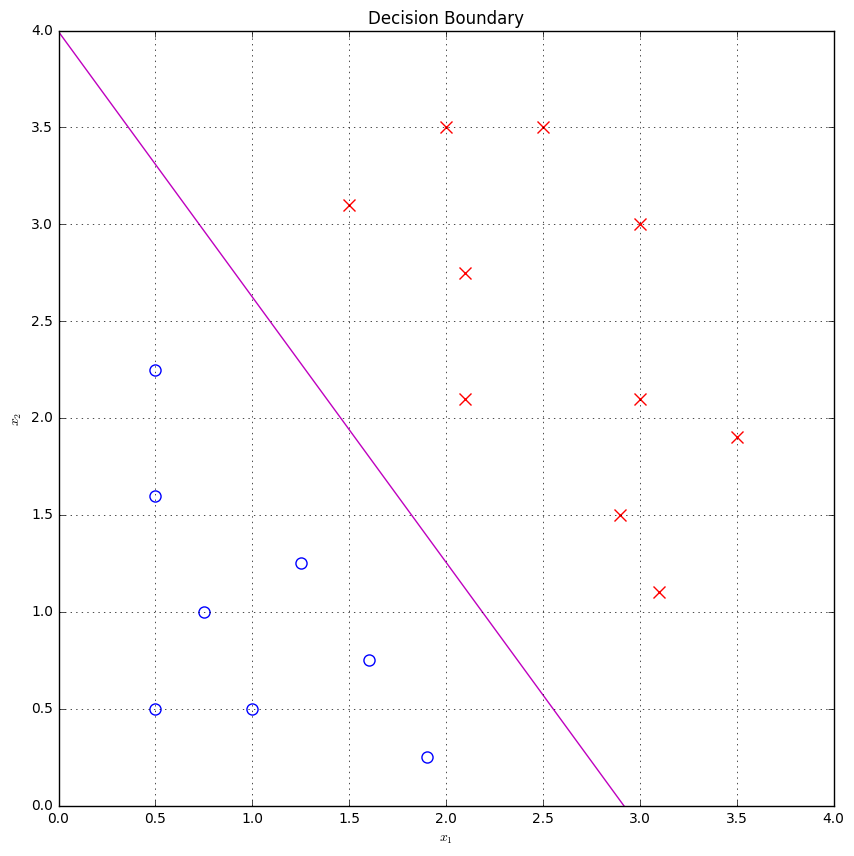

In [67]:
# display the computed classification boundary with the original set of data points
plt.figure(figsize=(10,10))

# plot the points in our two categories, y=0 and y=1, using markers to indicated
# the category or output
neg_idx = np.where(y == 0)
pos_idx = np.where(y == 1)
plt.plot(X[neg_idx,0], X[neg_idx,1], 'bo', markersize=8, fillstyle='none', markeredgewidth=1) 
plt.plot(X[pos_idx,0], X[pos_idx,1], 'rx', markersize=8, markeredgewidth=1) 

# plot the line line described by the given optimal values of theta
# computed in previous cell
x1 = 0
y1 = -(theta[0] + theta[1] * x1) / theta[2]
x2 = 3
y2 = -(theta[0] + theta[1] * x2) / theta[2]
print (x1,y1), (x2,y2)
plt.plot([x1, x2], [y1,y2], 'm-')

# add some labels and titles
plt.axis([0, 4, 0, 4])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Decision Boundary')
plt.grid()

## Multiclass Classification

How to get logistic regression to work for more than 2 categories.  We often have (many) more than
2 categories.  

So given a data set with 3 (or more) classes, how do we extend logistic regression to deal with multiple
classes?  The simple answer is to build and fit multiple classifiers using one-vs-all (or
one-vs-rest) encoding.  For example, if we have x classes, we will need to build x classifiers.  Once we have done this,
to make a prediction on a new input, we simply get all x hypothesis from our x classifiers, and we
choose the one that is the most confident (e.g. that has the highest output).

Lets build up a example of multiclass classification using a relatively simple data set that contains
3 classes:

In [68]:
iris = pd.read_csv('data/iris.data', names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'category'])
X = iris.ix[:,0:4].as_matrix()

# create a y from the class column, convert the string class names 
# Iris-setosa = 0, Iris-versicolor=1, Iris-virginica=2
m,n = X.shape
y = np.zeros(m)

mask = (iris.category == 'Iris-setosa').as_matrix() # create a boolean mask for fancy indexing
y[mask] = 0
mask = (iris.category == 'Iris-versicolor').as_matrix() 
y[mask] = 1
mask = (iris.category == 'Iris-virginica').as_matrix() 
y[mask] = 2

print X.shape
#print X
print y.shape
#print y

(150, 4)
(150,)


The iris data set consists of a sample of 150 flowers.  Each flower was measured using 4 features
(sepal length, sepal width, petal length, and petal width).  There were 3 species or categories of
Iris flowers in the data set: setosa, versicolor and virginica.  We can visualize any two of the 4
features like this to see the relationship of the 3 classes of flower:

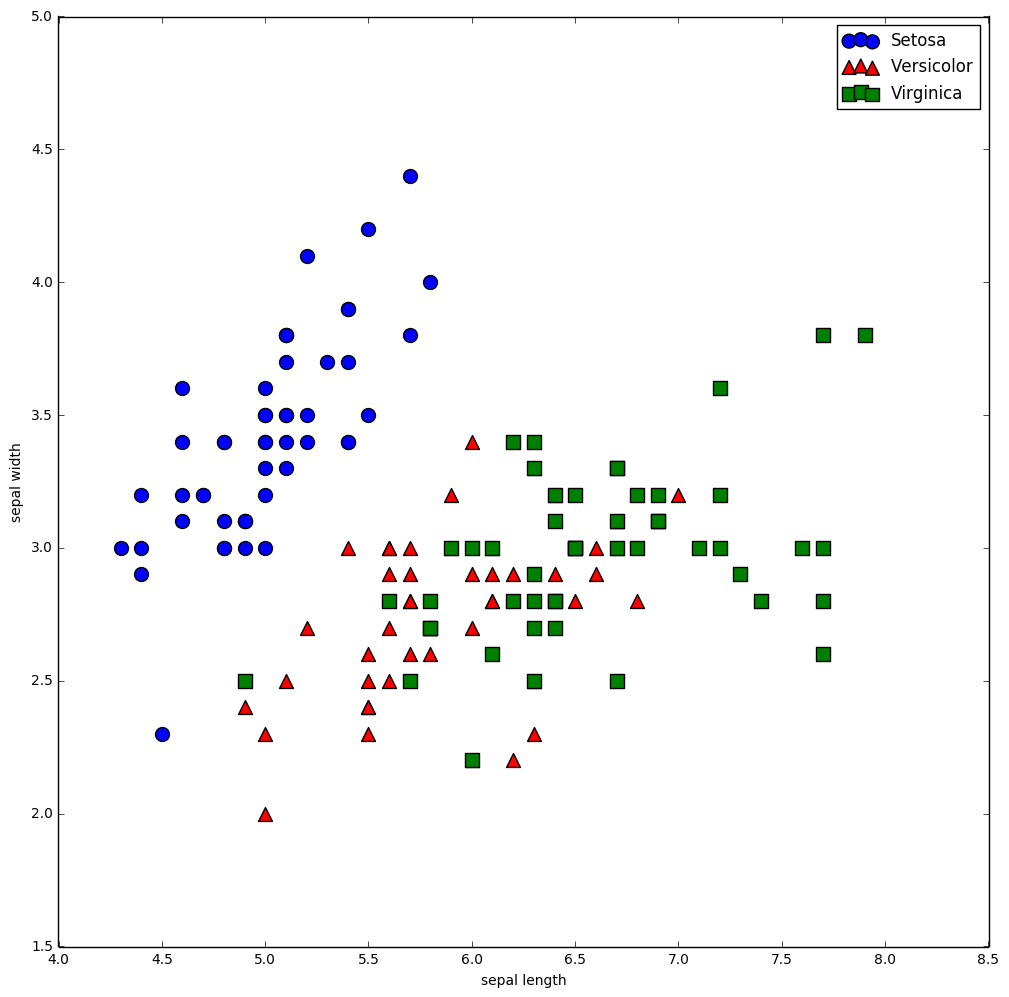

In [69]:
plt.figure(figsize=(12,12))
plt.scatter(X[y==0, 0], X[y==0, 1], c='b', marker='o', s=100, label='Setosa')
plt.scatter(X[y==1, 0], X[y==1, 1], c='r', marker='^', s=100, label='Versicolor')
plt.scatter(X[y==2, 0], X[y==2, 1], c='g', marker='s', s=100, label='Virginica')
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend()

As you can see the 3 classes of flowers are separated somewhat if we only look at these 2 features of the 4.
Setosa is easiest to identify (having small sepal lengths and large sepal widths).  It would be much harder
just using these 2 features to classify versicolor from virginica.

Lets build a multiclass logistic classifier for this problem.  We need to build 3 classifiers, one for
each of our 3 classes.  Each classifier needs to have 4 inputs for the 4 measured features.

Lets build a logistic classifier for the Setosa vs. not Setosa first.  We need a new
y encoding that is 1 for all the setosa, and 0 for the others first:

In [70]:
y_setosa = np.zeros(m)
y_setosa[y==0] = 1.0
print y_setosa

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.]


With this for our correct output, we can train a logistic classifier with 4 inputs
(plus 1 more to represent our bias) as we did above:

In [71]:
m, n = X.shape # m = number of inputs, n = number of features
X_ones = np.ones((m, n+1))
X_ones[:, 1:] = X

theta = np.zeros( n+1 )

# lets find optimal theata parameters, given our cost and gradient function implementations
from scipy.optimize import minimize
res = minimize(compute_classification_cost, theta, method='Newton-CG', 
               jac=compute_classification_cost_gradients, 
               args=(X_ones, y_setosa), options={'disp': True})
print res.x # res is n object, the x variable in res has the optimized parameters
theta_setosa = res.x

Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 17
         Function evaluations: 18
         Gradient evaluations: 144
         Hessian evaluations: 0
[ 1.22498015  1.92200088  5.88418657 -9.73802599 -4.8450407 ]


How does this classifier do?  Lets see the hypothesized outputs the classifier gets for our data:

In [72]:
def threshold(h, level=0.5):
    m = h.size
    return np.where(h < level, np.zeros(m), np.ones(m))

#hypothesis = g(np.dot(theta_setosa.T, X_ones.T))
hypothesis = threshold(g(np.dot(theta_setosa.T, X_ones.T)))
print hypothesis

# lets see how many we got correct
print np.sum(hypothesis == y_setosa)

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.]
150


We actually get all 150 right in choosing between setosa and non-setosa.  Lets see how well we do creating
classifiers for the other 2 categories of Iris flowers:

In [73]:
### train and test the versicolor
y_versicolor = np.zeros(m)
y_versicolor[y==1] = 1.0

theta_versicolor = np.zeros( n+1 )
res = minimize(compute_classification_cost, theta_versicolor, method='Newton-CG', jac=compute_classification_cost_gradients, 
               args=(X_ones, y_versicolor), options={'disp': True})
theta_versicolor = res.x
hypothesis = threshold(g(np.dot(theta_versicolor.T, X_ones.T)))
print np.sum(hypothesis == y_versicolor)

Optimization terminated successfully.
         Current function value: 0.485883
         Iterations: 14
         Function evaluations: 18
         Gradient evaluations: 499
         Hessian evaluations: 0
111


In [74]:
### train and test the versicolor
y_virginica = np.zeros(m)
y_virginica[y==2] = 1.0

theta_virginica = np.zeros( n+1 )
res = minimize(compute_classification_cost, theta_virginica, method='Newton-CG', jac=compute_classification_cost_gradients, 
               args=(X_ones, y_virginica), options={'disp': True})
theta_virginica = res.x
hypothesis = threshold(g(np.dot(theta_virginica.T, X_ones.T)))
print np.sum(hypothesis == y_virginica)

Optimization terminated successfully.
         Current function value: 0.039662
         Iterations: 20
         Function evaluations: 22
         Gradient evaluations: 385
         Hessian evaluations: 0
148


The classifier for virginica only got 2 wrong, but we got 39 wrong for the versicolor classifier.  It may not
be immediately obvious how well the three classifiers are doing when combined.  To combine multiple classifiers,
we need to get the hypothesis for all three classifiers, and choose the class for the classifier that had the 
highest output.  A straightforwad approach is to iterate through all the hypothesis, find which one had
the highest activation, then compare it to the correct answer:

In [75]:
hypothesis_setosa = g(np.dot(theta_setosa.T, X_ones.T))
hypothesis_versicolor = g(np.dot(theta_versicolor.T, X_ones.T))
hypothesis_virginica = g(np.dot(theta_virginica.T, X_ones.T))
hypothesis_class = np.zeros(m)

for i in range(m):
    # argmax will return the index 0,1 or 2 of the item in the tuple that is the maximum of the 3
    c = np.argmax( (hypothesis_setosa[i], hypothesis_versicolor[i], hypothesis_virginica[i]) )
    hypothesis_class[i] = c
    
    # if you want to compare the outputs for the 3 classes for each input by hand, uncomment this next line                                                                                            
    print "%03d: %0.8f %0.8f %0.8f  class=%d" %  (i, hypothesis_setosa[i], hypothesis_versicolor[i], hypothesis_virginica[i], c)

print np.sum(y == hypothesis_class)


000: 0.99999996 0.08197940 0.00000000  class=0
001: 0.99999887 0.27378427 0.00000000  class=0
002: 0.99999981 0.16648175 0.00000000  class=0
003: 0.99999704 0.25966652 0.00000000  class=0
004: 0.99999997 0.06486276 0.00000000  class=0
005: 0.99999989 0.02287902 0.00000000  class=0
006: 0.99999969 0.09263546 0.00000000  class=0
007: 0.99999977 0.12104068 0.00000000  class=0
008: 0.99999468 0.36095875 0.00000000  class=0
009: 0.99999898 0.29878351 0.00000000  class=0
010: 0.99999998 0.05129419 0.00000000  class=0
011: 0.99999909 0.14159077 0.00000000  class=0
012: 0.99999916 0.33630315 0.00000000  class=0
013: 0.99999988 0.28024759 0.00000000  class=0
014: 1.00000000 0.01417201 0.00000000  class=0
015: 1.00000000 0.00415300 0.00000000  class=0
016: 1.00000000 0.01373334 0.00000000  class=0
017: 0.99999993 0.06379416 0.00000000  class=0
018: 0.99999993 0.03619929 0.00000000  class=0
019: 0.99999997 0.03260736 0.00000000  class=0
020: 0.99999924 0.13897304 0.00000000  class=0
021: 0.999999

The final sum shows that, choosing the classifier that has maximum activation, we are getting 147 out of
the 150 items we trained with correctly classified using our hand build classifier.

You should note that this test of our classifier is not really a good test of how well the classifier
will perform in general.  We are testing the performance of the classifier on the same data that we used to
determine the optimal Theta parameters of the model.  These parameters may be overfitted to work well with 
the data we had to supervise our learning with.  But they may not generalize well to unseen data.
A fairer test would be to see how well the network does on classifying data it
has never seen before.  To do this we would need additional data, or we would instead have to hold back some of
the data from our training and then test it on this test set.  We will look more at testing and training data
later in this course.

Also, I wouldn't usually ever train a multiclass logistic classifier by hand like this, though it is 
instructional to see how it is done once.  If we want to perform linear or logistic regression, there are many
available libraries and third-party solutions.  For example, the scikit-learn library provides a 
comprehensive set of machine learning regression and classifier methods for the Python language.  If we needed
to build a logistic classifier for the Iris data set, we could use scikit-learn like this:

(This example is taken from scikit-learn documentation.  The example on the iris dataset
is [here](http://scikit-learn.org/stable/auto_examples/linear_model/plot_iris_logistic.html)
you can find all of the scikit-learn documentation [here](http://scikit-learn.org/stable/documentation.html).  The next cell will of course
require you to have installed the scikit-learn Python library on your system in order to work.)

In [76]:
from sklearn import linear_model # the linear_model can be used to create a linear logistic classifier

# create a logistic regression model, and fit model to the input data, using
# supervised learning of the correct classes provided in y
logreg = linear_model.LogisticRegression()
logreg.fit(X, y)

hypothesis = logreg.predict(X)
print np.sum(hypothesis == y)

144
